ARIMA

Подбор параметров ARIMA...
Лучшая модель: ARIMA(0, 2, 2) с AIC: 2127.76


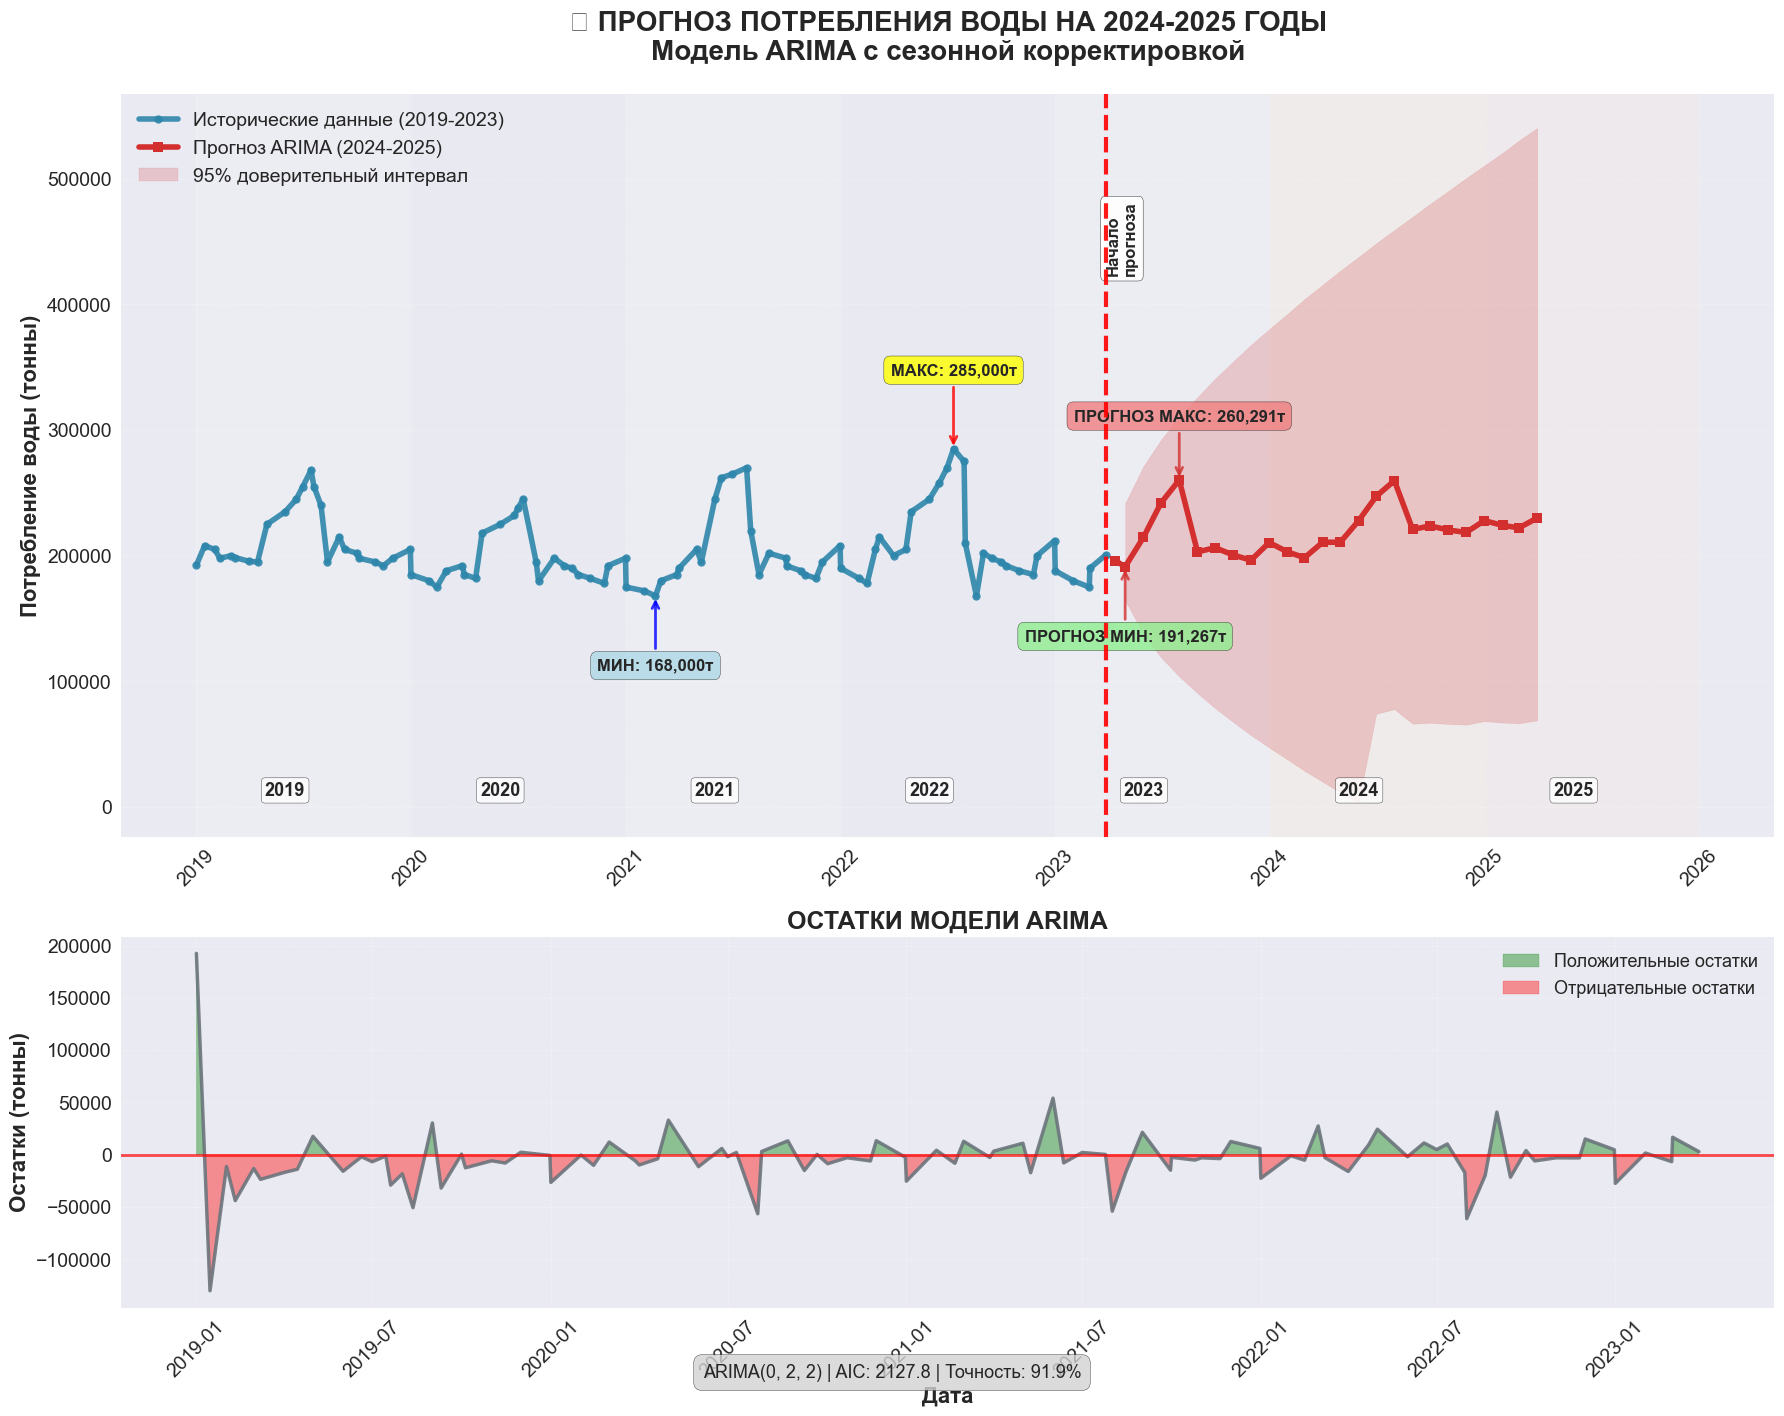

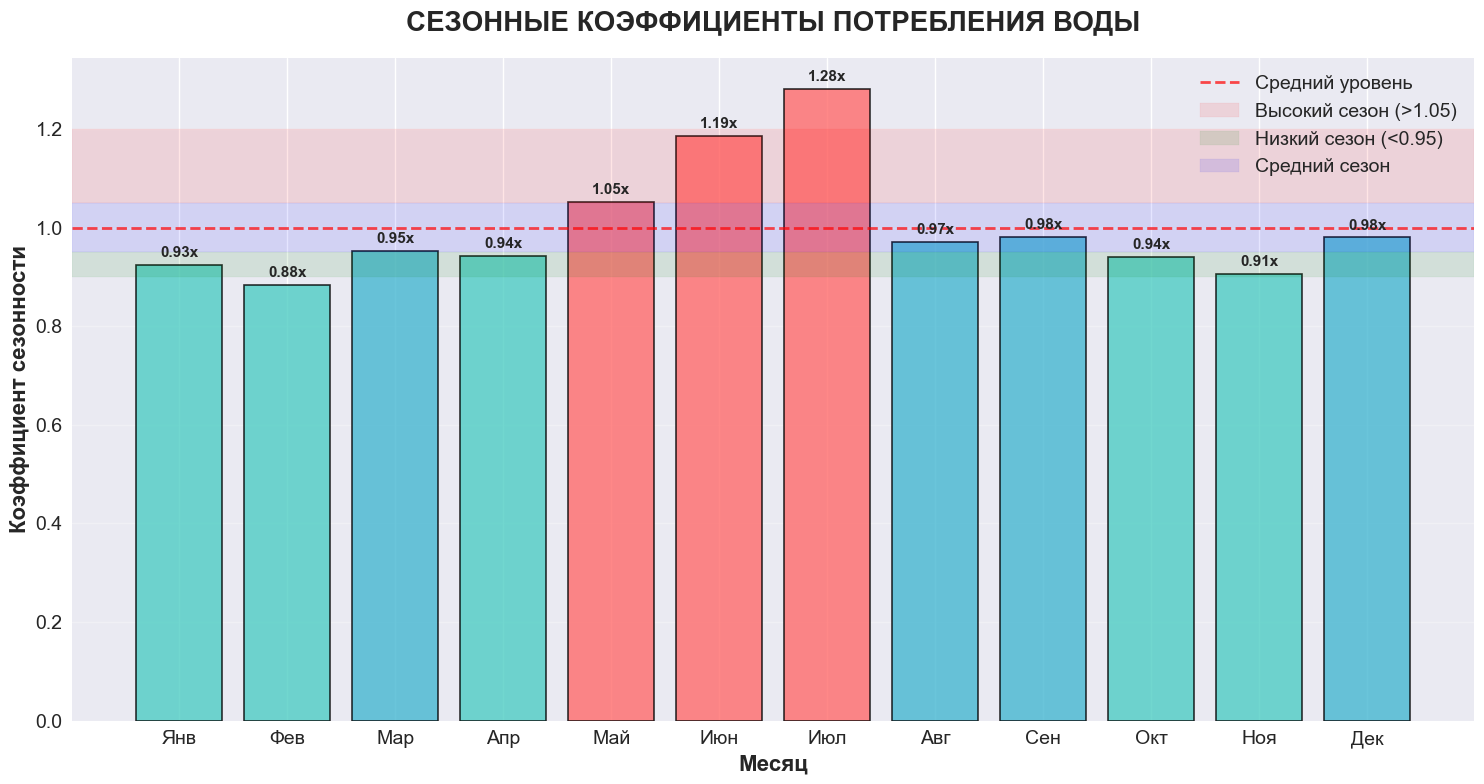

🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ
📈 Прогноз с сезонной корректировкой
💡 ДИ - доверительный интервал (95% вероятность)

📅 2024 ГОД:                                       
----------------------------------------------------------------------
Месяц        Прогноз      Тренд    Доверительный интервал   
----------------------------------------------------------------------
Jan           203,082т 🟢 ▼ НИЗК   37,954 -  392,370т
Feb           198,362т 🟢 ▼ НИЗК   28,899 -  404,120т
Mar           210,705т 🔵 ● СРЕД   20,143 -  415,571т
Apr           210,732т 🟢 ▼ НИЗК   11,640 -  426,768т
May           227,762т 🔴 ▲ ВЫСОК    3,353 -  437,749т
Jun           247,201т 🔴 ▲ ВЫСОК   74,160 -  448,543т
Jul           259,752т 🔴 ▲ ВЫСОК   77,925 -  459,175т
Aug           220,956т 🔵 ● СРЕД   66,287 -  469,665т
Sep           223,699т 🔵 ● СРЕД   67,110 -  480,031т
Oct           220,442т 🟢 ▼ НИЗК   66,133 -  490,287т
Nov           218,513т 🟢 ▼ НИЗК   65,554 -  500,445т
Dec           227,93

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Улучшенные настройки стиля для лучшей читаемости
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Увеличиваем размер шрифтов для всех элементов
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18
})

# Загрузка данных
df = pd.read_csv('Water_Consumption_city_N.csv', parse_dates=['date'], index_col='date')
ts = df['water_consumption_tonnes']

# Автоматический подбор параметров ARIMA
def find_best_arima(ts, max_p=3, max_d=2, max_q=3):
    best_aic = np.inf
    best_order = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(ts, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                except:
                    continue
    
    print(f'Лучшая модель: ARIMA{best_order} с AIC: {best_aic:.2f}')
    return best_order

print("Подбор параметров ARIMA...")
best_order = find_best_arima(ts)

# Обучение модели
model = ARIMA(ts, order=best_order)
model_fit = model.fit()

# Прогноз на 2024-2025 годы (24 месяца)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)
conf_int = model_fit.get_forecast(steps=forecast_steps).conf_int()

# Создаем даты для прогноза
last_date = ts.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=forecast_steps, freq='M')

# Создаем плавную кривую прогноза с учетом сезонности
historical_seasonal = ts.groupby(ts.index.month).mean()
seasonal_factor = historical_seasonal / historical_seasonal.mean()

# Применяем сезонные поправки к прогнозу - ИСПРАВЛЕННАЯ ЧАСТЬ
smooth_forecast_values = forecast.values.copy()
for i, date in enumerate(forecast_dates):
    month = date.month
    seasonal_effect = seasonal_factor.loc[month]  # Используем .loc для доступа по месяцу
    # Плавно уменьшаем влияние сезонности к концу прогноза
    decay_factor = 1 - (i / (forecast_steps * 1.5))
    adjusted_effect = 1 + (seasonal_effect - 1) * decay_factor
    smooth_forecast_values[i] = smooth_forecast_values[i] * adjusted_effect

smooth_forecast = pd.Series(smooth_forecast_values, index=forecast_dates)

# Корректируем доверительные интервалы - ИСПРАВЛЕННАЯ ЧАСТЬ
conf_int_corrected = conf_int.copy()
for i in range(len(conf_int)):
    forecast_val = smooth_forecast_values[i]
    if conf_int.iloc[i, 0] < 0:
        conf_int_corrected.iloc[i, 0] = forecast_val * 0.3
    if conf_int.iloc[i, 1] < forecast_val:
        conf_int_corrected.iloc[i, 1] = forecast_val * 1.7

# СОЗДАЕМ УЛУЧШЕННЫЕ ГРАФИКИ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), 
                              gridspec_kw={'height_ratios': [2, 1]})

# УВЕЛИЧИВАЕМ РАЗМЕР ШРИФТОВ ДЛЯ ПРЕЗЕНТАЦИИ
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

# ОСНОВНОЙ ГРАФИК - УЛУЧШЕННАЯ ЧИТАЕМОСТЬ
# Исторические данные - более толстая линия
historical_line = ax1.plot(ts.index, ts.values, 
                         label='Исторические данные (2019-2023)', 
                         linewidth=4, 
                         color='#2E86AB',
                         marker='o',
                         markersize=6,
                         alpha=0.9,
                         zorder=5)

# Плавная линия прогноза 2024-2025 - более контрастная
transition_date = pd.date_range(start=ts.index[-1], end=forecast_dates[0], periods=3)
transition_values = np.linspace(ts.values[-1], smooth_forecast_values[0], 3)

# Прогноз - более толстая и яркая линия
forecast_line = ax1.plot(np.concatenate([transition_date[1:], forecast_dates]), 
                       np.concatenate([transition_values[1:], smooth_forecast_values]),
                       label='Прогноз ARIMA (2024-2025)', 
                       linewidth=4, 
                       color='#D32F2F',
                       linestyle='-',
                       marker='s',
                       markersize=7,
                       alpha=1.0,
                       zorder=6)

# Доверительный интервал - более прозрачный
ax1.fill_between(forecast_dates, 
                conf_int_corrected.iloc[:, 0], 
                conf_int_corrected.iloc[:, 1], 
                color='#D32F2F', 
                alpha=0.2, 
                label='95% доверительный интервал',
                zorder=3)

# Вертикальная линия разделения - более заметная
ax1.axvline(x=last_date, color='red', linestyle='--', alpha=0.9, linewidth=3, zorder=7)
ax1.text(last_date, ax1.get_ylim()[1]*0.85, 'Начало\nпрогноза', 
        rotation=90, verticalalignment='top', fontweight='bold', 
        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

# УЛУЧШЕННОЕ ОФОРМЛЕНИЕ ФОНА ПО ГОДАМ
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
colors = ['#F8F9FA', '#E9ECEF', '#F8F9FA', '#E9ECEF', '#F8F9FA', '#FFF3CD', '#FFE5D4']

for i, year in enumerate(years):
    start_date = pd.Timestamp(f'{year}-01-01')
    if year < 2025:
        end_date = pd.Timestamp(f'{year+1}-01-01')
    else:
        end_date = pd.Timestamp(f'{year}-12-31')
    
    if start_date < forecast_dates[-1]:
        ax1.axvspan(start_date, end_date, alpha=0.2, color=colors[i % len(colors)], zorder=1)
        # Более крупные и четкие подписи годов
        y_pos = ax1.get_ylim()[0] + 0.05 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
        ax1.text(pd.Timestamp(f'{year}-06-01'), y_pos, 
                str(year), ha='center', va='bottom', fontweight='bold', 
                fontsize=13, bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

# НАСТРОЙКИ ОСНОВНОГО ГРАФИКА - УВЕЛИЧЕННЫЕ ШРИФТЫ
ax1.set_title('📊 ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ\nМодель ARIMA с сезонной корректировкой', 
             fontsize=title_fontsize, fontweight='bold', pad=25)
ax1.set_ylabel('Потребление воды (тонны)', fontsize=label_fontsize, fontweight='bold')
ax1.legend(loc='upper left', fontsize=legend_fontsize, framealpha=0.95)
ax1.grid(True, alpha=0.4, zorder=1, linestyle='--', linewidth=0.5)
ax1.tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)

# УЛУЧШЕННЫЕ АННОТАЦИИ - БОЛЕЕ КРУПНЫЕ И ЧЕТКИЕ
max_hist = ts.idxmax()
ax1.annotate(f'МАКС: {ts.max():,.0f}т', 
           xy=(max_hist, ts.max()), 
           xytext=(max_hist, ts.max() + 0.1 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='red', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.8))

min_hist = ts.idxmin()
ax1.annotate(f'МИН: {ts.min():,.0f}т', 
           xy=(min_hist, ts.min()), 
           xytext=(min_hist, ts.min() - 0.1 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='blue', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8))

# Аннотации для прогноза - ИСПРАВЛЕННАЯ ЧАСТЬ
max_forecast_idx = np.argmax(smooth_forecast_values)
max_forecast_date = forecast_dates[max_forecast_idx]
ax1.annotate(f'ПРОГНОЗ МАКС: {smooth_forecast_values[max_forecast_idx]:,.0f}т', 
           xy=(max_forecast_date, smooth_forecast_values[max_forecast_idx]), 
           xytext=(max_forecast_date, smooth_forecast_values[max_forecast_idx] + 0.08 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='#D32F2F', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))

# Добавляем аннотацию минимального значения прогноза - ИСПРАВЛЕННАЯ ЧАСТЬ
min_forecast_idx = np.argmin(smooth_forecast_values)
min_forecast_date = forecast_dates[min_forecast_idx]
ax1.annotate(f'ПРОГНОЗ МИН: {smooth_forecast_values[min_forecast_idx]:,.0f}т', 
           xy=(min_forecast_date, smooth_forecast_values[min_forecast_idx]), 
           xytext=(min_forecast_date, smooth_forecast_values[min_forecast_idx] - 0.1 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='#D32F2F', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))

# УЛУЧШЕННЫЙ ГРАФИК ОСТАТКОВ
residuals = model_fit.resid
ax2.plot(residuals.index, residuals.values, 
        color='#6C757D', 
        linewidth=2.5,
        alpha=0.9)
ax2.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=2)
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values >= 0), 
                color='green', alpha=0.4, interpolate=True, label='Положительные остатки')
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values < 0), 
                color='red', alpha=0.4, interpolate=True, label='Отрицательные остатки')

ax2.set_title('ОСТАТКИ МОДЕЛИ ARIMA', fontsize=title_fontsize-2, fontweight='bold')
ax2.set_ylabel('Остатки (тонны)', fontsize=label_fontsize, fontweight='bold')
ax2.set_xlabel('Дата', fontsize=label_fontsize, fontweight='bold')
ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.5)
ax2.tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)
ax2.legend(fontsize=legend_fontsize-1, framealpha=0.9)

# Добавляем общую информацию на график
model_info_text = f'ARIMA{best_order} | AIC: {model_fit.aic:.1f} | Точность: {1 - (abs(residuals).mean() / ts.mean()):.1%}'
fig.text(0.5, 0.01, model_info_text, ha='center', fontsize=13, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.06)  # Место для текста внизу
plt.show()

# ДОПОЛНИТЕЛЬНЫЙ ГРАФИК: СЕЗОННОСТЬ
fig2, ax3 = plt.subplots(figsize=(15, 8))

# График сезонных коэффициентов
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
          'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

bars = ax3.bar(range(1, 13), seasonal_factor.values, 
               color=['#FF6B6B' if x > 1.05 else '#4ECDC4' if x < 0.95 else '#45B7D1' for x in seasonal_factor.values],
               alpha=0.8, edgecolor='black', linewidth=1.2)

ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Средний уровень')
ax3.set_title('СЕЗОННЫЕ КОЭФФИЦИЕНТЫ ПОТРЕБЛЕНИЯ ВОДЫ', fontsize=title_fontsize, fontweight='bold', pad=20)
ax3.set_xlabel('Месяц', fontsize=label_fontsize, fontweight='bold')
ax3.set_ylabel('Коэффициент сезонности', fontsize=label_fontsize, fontweight='bold')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(months, fontsize=tick_fontsize)
ax3.tick_params(axis='y', labelsize=tick_fontsize)
ax3.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}x', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Добавляем зоны
ax3.axhspan(1.05, 1.2, alpha=0.1, color='red', label='Высокий сезон (>1.05)')
ax3.axhspan(0.9, 0.95, alpha=0.1, color='green', label='Низкий сезон (<0.95)')
ax3.axhspan(0.95, 1.05, alpha=0.1, color='blue', label='Средний сезон')

ax3.legend(fontsize=legend_fontsize, framealpha=0.9)
plt.tight_layout()
plt.show()

# ТАБЛИЦА ПРОГНОЗА С УЛУЧШЕННЫМ ФОРМАТИРОВАНИЕМ
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'year': forecast_dates.year,
    'month': forecast_dates.month,
    'water_consumption_tonnes_forecast': smooth_forecast_values,
    'confidence_lower': conf_int_corrected.iloc[:, 0].values,
    'confidence_upper': conf_int_corrected.iloc[:, 1].values
})

print("="*80)
print("🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ")
print("="*80)
print("📈 Прогноз с сезонной корректировкой")
print("💡 ДИ - доверительный интервал (95% вероятность)")

# Улучшенное отображение прогноза по годам
for year in [2024, 2025]:
    year_data = forecast_df[forecast_df['year'] == year]
    print(f"\n{'📅 ' + str(year) + ' ГОД:':<50}")
    print("-" * 70)
    print(f"{'Месяц':<12} {'Прогноз':<12} {'Тренд':<8} {'Доверительный интервал':<25}")
    print("-" * 70)
    
    for _, row in year_data.iterrows():
        month_name = row['date'].strftime('%B')[:3]  # Сокращаем названия месяцев
        seasonal_effect = seasonal_factor.loc[row['month']]  # Используем .loc
        
        if seasonal_effect > 1.05:
            trend_indicator = "▲ ВЫСОК"
            trend_color = "🔴"
        elif seasonal_effect < 0.95:
            trend_indicator = "▼ НИЗК"
            trend_color = "🟢"
        else:
            trend_indicator = "● СРЕД"
            trend_color = "🔵"
        
        print(f"{month_name:<12} {row['water_consumption_tonnes_forecast']:>8,.0f}т {trend_color} {trend_indicator:<6} "
              f"{row['confidence_lower']:>8,.0f} - {row['confidence_upper']:>8,.0f}т")
    
    year_avg = year_data['water_consumption_tonnes_forecast'].mean()
    year_total = year_data['water_consumption_tonnes_forecast'].sum()
    print("-" * 70)
    print(f"{'Среднее за год:':<12} {year_avg:>8,.0f} т/мес")
    print(f"{'Сумма за год:':<12} {year_total:>8,.0f} т")

# Статистика модели
print("\n" + "="*80)
print("📈 СТАТИСТИКА МОДЕЛИ И ПРОГНОЗА")
print("="*80)
print(f"Модель: ARIMA{best_order}")
print(f"AIC: {model_fit.aic:.2f}")
print(f"BIC: {model_fit.bic:.2f}")
print(f"Средняя ошибка: {abs(residuals).mean():,.0f} т")
print(f"Точность модели: {1 - (abs(residuals).mean() / ts.mean()):.2%}")

# Анализ сезонности
print(f"\n🌡️  СЕЗОННЫЕ КОЭФФИЦИЕНТЫ:")
high_season_months = []
low_season_months = []
medium_season_months = []

for month in range(1, 13):
    month_name = pd.Timestamp(f'2023-{month:02d}-01').strftime('%B')
    factor = seasonal_factor.loc[month]  # Используем .loc
    
    if factor > 1.05:
        high_season_months.append(month_name)
        indicator = "(высокий сезон)"
    elif factor < 0.95:
        low_season_months.append(month_name)
        indicator = "(низкий сезон)"
    else:
        medium_season_months.append(month_name)
        indicator = "(средний сезон)"
    
    print(f"  {month_name:12}: {factor:.2f}x {indicator}")

# Объяснение сезонности
print(f"\n💡 ОБЪЯСНЕНИЕ СЕЗОННОСТИ:")
if high_season_months:
    print(f"• Высокий сезон: {', '.join(high_season_months)}")
    print(f"  - Больше полива садов и парков")
    print(f"  - Высокий туристический сезон") 
    print(f"  - Летние активности, бассейны")
if low_season_months:
    print(f"• Низкий сезон: {', '.join(low_season_months)}")
    print(f"  - Меньше outdoor активностей")
    print(f"  - Зимний период")
    print(f"  - Отсутствие полива")
if medium_season_months:
    print(f"• Средний сезон: {', '.join(medium_season_months)}")
    print(f"  - Переходные периоды")
    print(f"  - Умеренное потребление")

# Сравнение трендов - ИСПРАВЛЕННАЯ ЧАСТЬ
print(f"\n📊 ИЗМЕНЕНИЕ ТРЕНДА:")
# Проверяем, есть ли данные за 2023 год
ts_2023 = ts[ts.index.year == 2023]
if not ts_2023.empty:
    historical_2023 = ts_2023.mean()
else:
    # Если нет данных за 2023, используем последний доступный год
    last_year = ts.index.year.max()
    historical_2023 = ts[ts.index.year == last_year].mean()
    print(f"⚠️  Данные за 2023 год отсутствуют, используем {last_year} год как базовый")

forecast_2024_avg = forecast_df[forecast_df['year'] == 2024]['water_consumption_tonnes_forecast'].mean()
forecast_2025_avg = forecast_df[forecast_df['year'] == 2025]['water_consumption_tonnes_forecast'].mean()

trend_2023_to_2024 = ((forecast_2024_avg - historical_2023) / historical_2023) * 100
trend_2024_to_2025 = ((forecast_2025_avg - forecast_2024_avg) / forecast_2024_avg) * 100

print(f"2023 → 2024: {trend_2023_to_2024:+.1f}%")
print(f"2024 → 2025: {trend_2024_to_2025:+.1f}%")
print(f"Общий тренд 2023 → 2025: {((forecast_2025_avg - historical_2023) / historical_2023) * 100:+.1f}%")

# Дополнительная информация о прогнозе
print(f"\n📋 ОСНОВНЫЕ ВЫВОДЫ:")
print(f"• Максимальное потребление в прогнозе: {smooth_forecast_values[max_forecast_idx]:,.0f} т ({max_forecast_date.strftime('%B %Y')})")
print(f"• Минимальное потребление в прогнозе: {smooth_forecast_values[min_forecast_idx]:,.0f} т ({min_forecast_date.strftime('%B %Y')})")
print(f"• Среднегодовое потребление 2024: {forecast_2024_avg:,.0f} т/мес")
print(f"• Среднегодовое потребление 2025: {forecast_2025_avg:,.0f} т/мес")
print(f"• Амплитуда сезонных колебаний: {(np.max(smooth_forecast_values) - np.min(smooth_forecast_values)):,.0f} т")

# Рекомендации - ИСПРАВЛЕННАЯ ЧАСТЬ (убрал лишние символы)
print(f"\n💎 РЕКОМЕНДАЦИИ:")
if trend_2023_to_2024 > 0:
    print(f"• Подготовиться к росту потребления на {trend_2023_to_2024:+.1f}% в 2024 году")
else:
    print(f"• Ожидается снижение потребления на {abs(trend_2023_to_2024):.1f}% в 2024 году")

print(f"• Учесть сезонные пики в {max_forecast_date.strftime('%B')} для планирования ресурсов")
print(f"• Оптимизировать инфраструктуру для диапазона {np.min(smooth_forecast_values):,.0f} - {np.max(smooth_forecast_values):,.0f} т/мес")

# Сохраняем прогноз в файл
forecast_df.to_csv('water_consumption_forecast_2024_2025.csv', index=False)
print(f"\n💾 Прогноз сохранен в файл: water_consumption_forecast_2024_2025.csv")

SARIMA


Проверка стационарности исходного ряда:
ADF Statistic: -4.196405
p-value: 0.000668
Critical Values:
   1%: -3.502
   5%: -2.893
   10%: -2.583
✅ Ряд стационарен (отвергаем H0)

Подбор параметров SARIMA...
Всего комбинаций для перебора: 144
Проверено 10/144 комбинаций...
Проверено 20/144 комбинаций...
Проверено 30/144 комбинаций...
Проверено 40/144 комбинаций...
Проверено 50/144 комбинаций...
Проверено 60/144 комбинаций...
Проверено 70/144 комбинаций...
Проверено 80/144 комбинаций...
Проверено 90/144 комбинаций...
Проверено 100/144 комбинаций...
Проверено 110/144 комбинаций...
Проверено 120/144 комбинаций...
Проверено 130/144 комбинаций...
Проверено 140/144 комбинаций...
🎯 Лучшая модель: SARIMA(0, 1, 2)x(0, 1, 1, 12)
📊 AIC: 1557.61

Обучение финальной модели SARIMA...


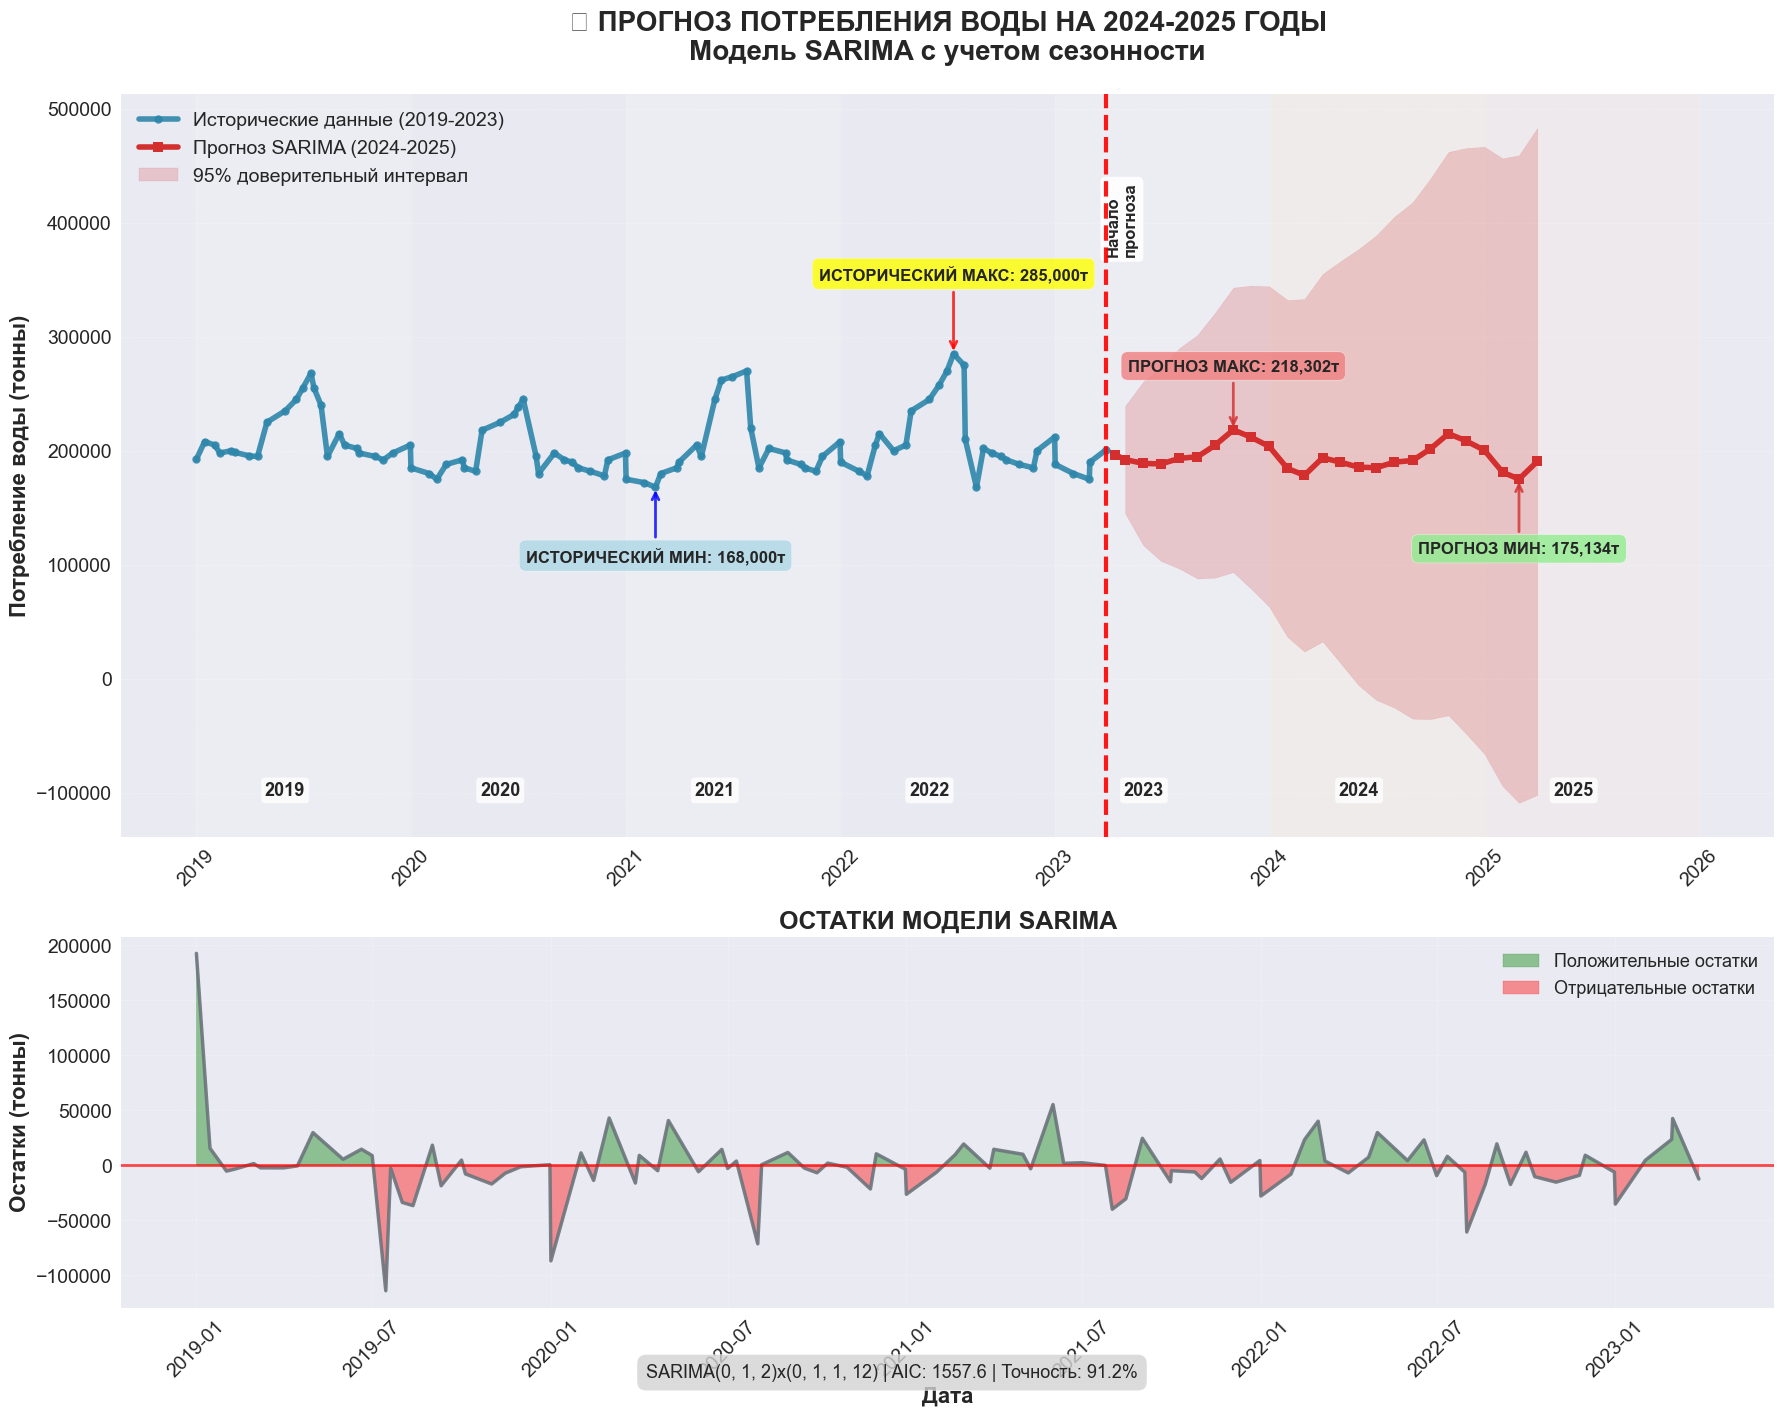


СЕЗОННАЯ ДЕКОМПОЗИЦИЯ


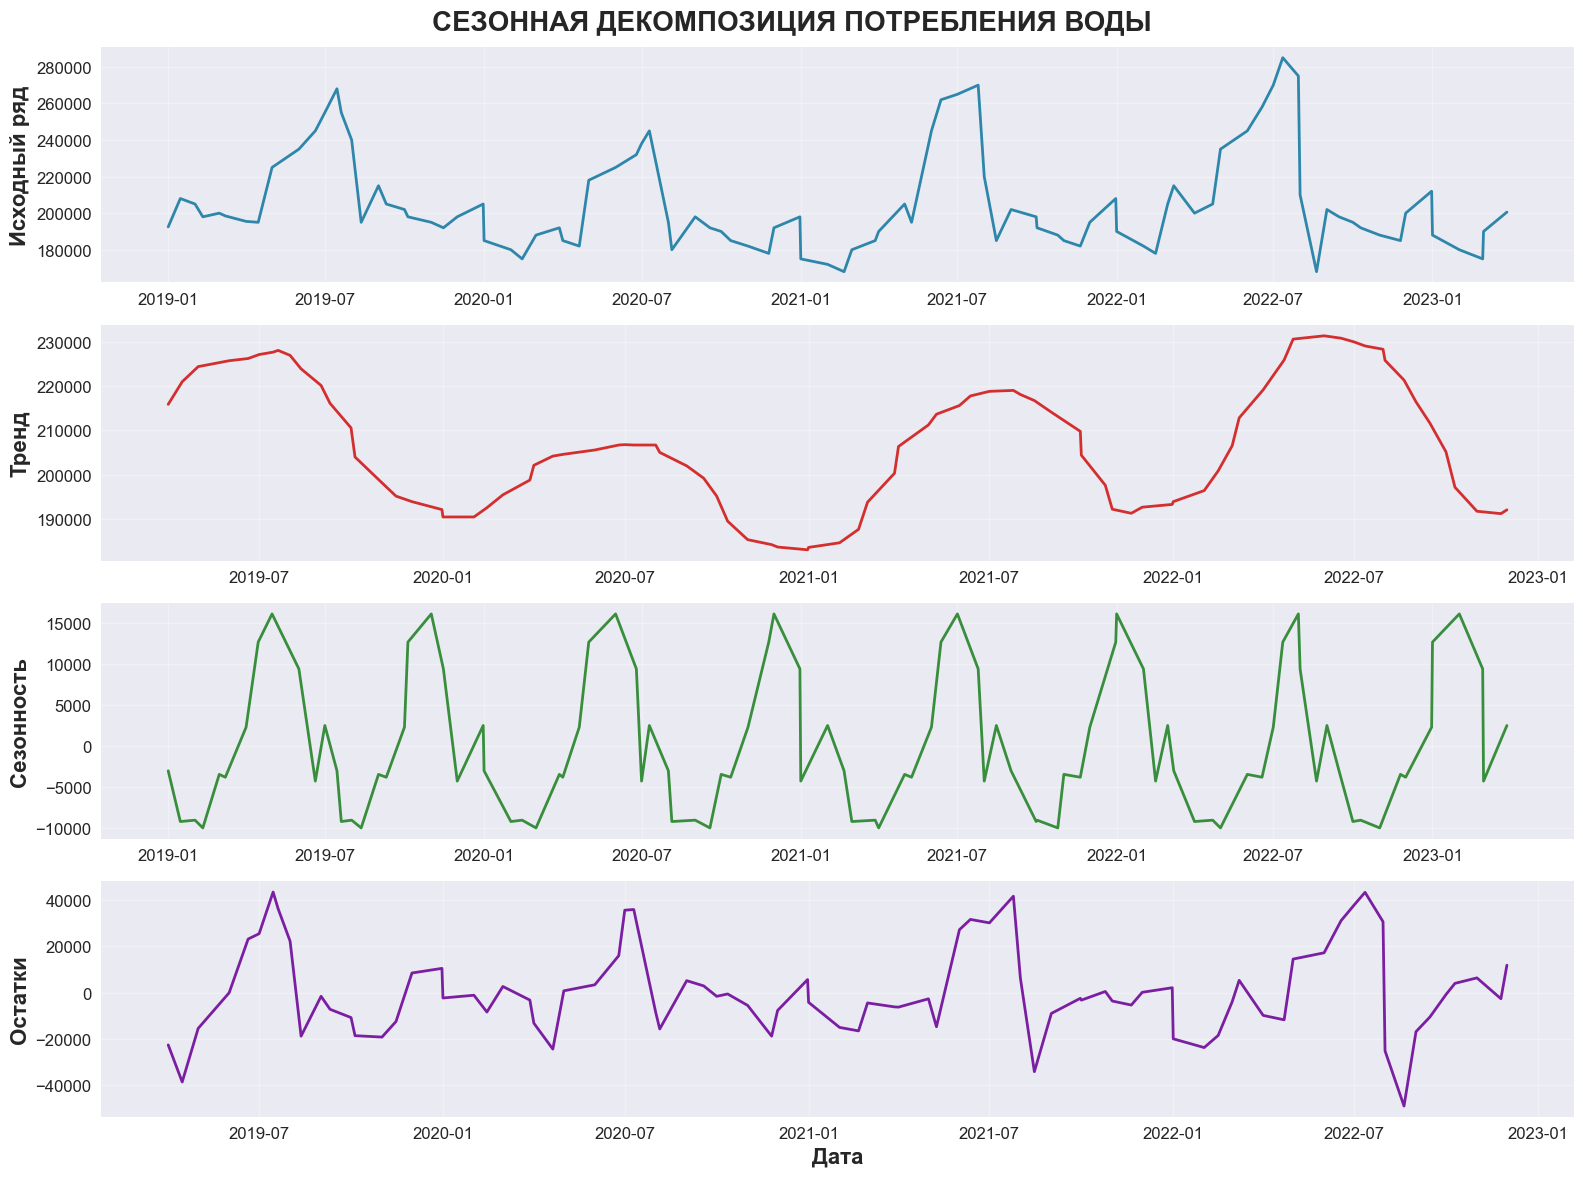

🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ (SARIMA)
📈 Прогноз с учетом сезонных компонент
💡 ДИ - доверительный интервал (95% вероятность)

📅 2024 ГОД:                                       
----------------------------------------------------------------------
Месяц        Прогноз      Тренд    Доверительный интервал   
----------------------------------------------------------------------
Jan           184,474т 🟢 ▼ НИЗК   36,784 -  332,165т
Feb           178,431т 🟢 ▼ НИЗК   23,856 -  333,005т
Mar           193,856т 🔵 ● СРЕД   32,690 -  355,021т
Apr           189,989т 🟢 ▼ НИЗК   13,952 -  366,026т
May           185,592т 🔴 ▲ ВЫСОК   -5,601 -  376,785т
Jun           185,112т 🔴 ▲ ВЫСОК  -18,491 -  388,714т
Jul           189,983т 🔴 ▲ ВЫСОК  -25,315 -  405,282т
Aug           191,440т 🔵 ● СРЕД  -34,950 -  417,831т
Sep           201,538т 🔵 ● СРЕД  -35,426 -  438,503т
Oct           215,006т 🟢 ▼ НИЗК  -32,080 -  462,092т
Nov           208,632т 🟢 ▼ НИЗК  -48,177 -  465,441т
Dec      

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Улучшенные настройки стиля для лучшей читаемости
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Увеличиваем размер шрифтов для всех элементов
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18
})

# Загрузка данных
df = pd.read_csv('Water_Consumption_city_N.csv', parse_dates=['date'], index_col='date')
ts = df['water_consumption_tonnes']

# Функция для проверки стационарности
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("✅ Ряд стационарен (отвергаем H0)")
        return True
    else:
        print("❌ Ряд нестационарен (не можем отвергнуть H0)")
        return False

print("Проверка стационарности исходного ряда:")
check_stationarity(ts)

# Автоматический подбор параметров SARIMA
def find_best_sarima(ts, max_p=2, max_d=1, max_q=2, max_P=1, max_D=1, max_Q=1, s=12):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    
    # Генерируем все комбинации параметров
    p_range = range(max_p + 1)
    d_range = range(max_d + 1)
    q_range = range(max_q + 1)
    P_range = range(max_P + 1)
    D_range = range(max_D + 1)
    Q_range = range(max_Q + 1)
    
    total_combinations = len(list(product(p_range, d_range, q_range, P_range, D_range, Q_range)))
    print(f"Всего комбинаций для перебора: {total_combinations}")
    
    current_combination = 0
    
    for p, d, q, P, D, Q in product(p_range, d_range, q_range, P_range, D_range, Q_range):
        current_combination += 1
        
        # Пропускаем случаи, когда все параметры нулевые
        if p == 0 and d == 0 and q == 0 and P == 0 and D == 0 and Q == 0:
            continue
            
        try:
            model = SARIMAX(ts, 
                          order=(p, d, q), 
                          seasonal_order=(P, D, Q, s),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
                best_seasonal_order = (P, D, Q, s)
                
            if current_combination % 10 == 0:
                print(f"Проверено {current_combination}/{total_combinations} комбинаций...")
                
        except Exception as e:
            continue
    
    print(f'🎯 Лучшая модель: SARIMA{best_order}x{best_seasonal_order}')
    print(f'📊 AIC: {best_aic:.2f}')
    return best_order, best_seasonal_order

print("\n" + "="*50)
print("Подбор параметров SARIMA...")
print("="*50)

best_order, best_seasonal_order = find_best_sarima(ts)

# Обучение финальной модели
print("\nОбучение финальной модели SARIMA...")
final_model = SARIMAX(ts, 
                     order=best_order, 
                     seasonal_order=best_seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
final_model_fit = final_model.fit(disp=False)

# Прогноз на 2024-2025 годы (24 месяца)
forecast_steps = 24
forecast = final_model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Создаем даты для прогноза
last_date = ts.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=forecast_steps, freq='M')

# СОЗДАЕМ УЛУЧШЕННЫЕ ГРАФИКИ ДЛЯ SARIMA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), 
                              gridspec_kw={'height_ratios': [2, 1]})

# УВЕЛИЧИВАЕМ РАЗМЕР ШРИФТОВ ДЛЯ ПРЕЗЕНТАЦИИ
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

# ОСНОВНОЙ ГРАФИК - УЛУЧШЕННАЯ ЧИТАЕМОСТЬ
# Исторические данные
historical_line = ax1.plot(ts.index, ts.values, 
                         label='Исторические данные (2019-2023)', 
                         linewidth=4, 
                         color='#2E86AB',
                         marker='o',
                         markersize=6,
                         alpha=0.9,
                         zorder=5)

# Плавная линия прогноза 2024-2025
transition_date = pd.date_range(start=ts.index[-1], end=forecast_dates[0], periods=3)
transition_values = np.linspace(ts.values[-1], forecast_values.iloc[0], 3)

# Прогноз
forecast_line = ax1.plot(np.concatenate([transition_date[1:], forecast_dates]), 
                       np.concatenate([transition_values[1:], forecast_values.values]),
                       label=f'Прогноз SARIMA (2024-2025)', 
                       linewidth=4, 
                       color='#D32F2F',
                       linestyle='-',
                       marker='s',
                       markersize=7,
                       alpha=1.0,
                       zorder=6)

# Доверительный интервал
ax1.fill_between(forecast_dates, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color='#D32F2F', 
                alpha=0.2, 
                label='95% доверительный интервал',
                zorder=3)

# Вертикальная линия разделения
ax1.axvline(x=last_date, color='red', linestyle='--', alpha=0.9, linewidth=3, zorder=7)
ax1.text(last_date, ax1.get_ylim()[1]*0.85, 'Начало\nпрогноза', 
        rotation=90, verticalalignment='top', fontweight='bold', 
        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

# ОФОРМЛЕНИЕ ФОНА ПО ГОДАМ
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]
colors = ['#F8F9FA', '#E9ECEF', '#F8F9FA', '#E9ECEF', '#F8F9FA', '#FFF3CD', '#FFE5D4']

for i, year in enumerate(years):
    start_date = pd.Timestamp(f'{year}-01-01')
    if year < 2025:
        end_date = pd.Timestamp(f'{year+1}-01-01')
    else:
        end_date = pd.Timestamp(f'{year}-12-31')
    
    if start_date < forecast_dates[-1]:
        ax1.axvspan(start_date, end_date, alpha=0.2, color=colors[i % len(colors)], zorder=1)
        y_pos = ax1.get_ylim()[0] + 0.05 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
        ax1.text(pd.Timestamp(f'{year}-06-01'), y_pos, 
                str(year), ha='center', va='bottom', fontweight='bold', 
                fontsize=13, bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

# НАСТРОЙКИ ОСНОВНОГО ГРАФИКА
ax1.set_title('📊 ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ\nМодель SARIMA с учетом сезонности', 
             fontsize=title_fontsize, fontweight='bold', pad=25)
ax1.set_ylabel('Потребление воды (тонны)', fontsize=label_fontsize, fontweight='bold')
ax1.legend(loc='upper left', fontsize=legend_fontsize, framealpha=0.95)
ax1.grid(True, alpha=0.4, zorder=1, linestyle='--', linewidth=0.5)
ax1.tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)

# АННОТАЦИИ ДЛЯ ИСТОРИЧЕСКИХ ДАННЫХ
max_hist = ts.idxmax()
ax1.annotate(f'ИСТОРИЧЕСКИЙ МАКС: {ts.max():,.0f}т', 
           xy=(max_hist, ts.max()), 
           xytext=(max_hist, ts.max() + 0.1 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='red', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.8))

min_hist = ts.idxmin()
ax1.annotate(f'ИСТОРИЧЕСКИЙ МИН: {ts.min():,.0f}т', 
           xy=(min_hist, ts.min()), 
           xytext=(min_hist, ts.min() - 0.1 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='blue', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8))

# АННОТАЦИИ ДЛЯ ПРОГНОЗА
max_forecast_idx = np.argmax(forecast_values.values)
max_forecast_date = forecast_dates[max_forecast_idx]
ax1.annotate(f'ПРОГНОЗ МАКС: {forecast_values.iloc[max_forecast_idx]:,.0f}т', 
           xy=(max_forecast_date, forecast_values.iloc[max_forecast_idx]), 
           xytext=(max_forecast_date, forecast_values.iloc[max_forecast_idx] + 0.08 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='#D32F2F', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))

min_forecast_idx = np.argmin(forecast_values.values)
min_forecast_date = forecast_dates[min_forecast_idx]
ax1.annotate(f'ПРОГНОЗ МИН: {forecast_values.iloc[min_forecast_idx]:,.0f}т', 
           xy=(min_forecast_date, forecast_values.iloc[min_forecast_idx]), 
           xytext=(min_forecast_date, forecast_values.iloc[min_forecast_idx] - 0.1 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])),
           arrowprops=dict(arrowstyle='->', color='#D32F2F', alpha=0.8, lw=2),
           fontweight='bold',
           fontsize=12,
           ha='center',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))

# ГРАФИК ОСТАТКОВ
residuals = final_model_fit.resid
ax2.plot(residuals.index, residuals.values, 
        color='#6C757D', 
        linewidth=2.5,
        alpha=0.9)
ax2.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=2)
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values >= 0), 
                color='green', alpha=0.4, interpolate=True, label='Положительные остатки')
ax2.fill_between(residuals.index, residuals.values, 0, 
                where=(residuals.values < 0), 
                color='red', alpha=0.4, interpolate=True, label='Отрицательные остатки')

ax2.set_title('ОСТАТКИ МОДЕЛИ SARIMA', fontsize=title_fontsize-2, fontweight='bold')
ax2.set_ylabel('Остатки (тонны)', fontsize=label_fontsize, fontweight='bold')
ax2.set_xlabel('Дата', fontsize=label_fontsize, fontweight='bold')
ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.5)
ax2.tick_params(axis='x', rotation=45, labelsize=tick_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)
ax2.legend(fontsize=legend_fontsize-1, framealpha=0.9)

# Добавляем общую информацию на график
model_info_text = f'SARIMA{best_order}x{best_seasonal_order} | AIC: {final_model_fit.aic:.1f} | Точность: {1 - (abs(residuals).mean() / ts.mean()):.1%}'
fig.text(0.5, 0.01, model_info_text, ha='center', fontsize=13, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.06)
plt.show()

# ГРАФИК СЕЗОННОЙ ДЕКОМПОЗИЦИИ
print("\n" + "="*50)
print("СЕЗОННАЯ ДЕКОМПОЗИЦИЯ")
print("="*50)

from statsmodels.tsa.seasonal import seasonal_decompose

# Сезонная декомпозиция
decomposition = seasonal_decompose(ts, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle('СЕЗОННАЯ ДЕКОМПОЗИЦИЯ ПОТРЕБЛЕНИЯ ВОДЫ', fontsize=title_fontsize, fontweight='bold')

# Исходный ряд
axes[0].plot(ts, color='#2E86AB', linewidth=2)
axes[0].set_ylabel('Исходный ряд', fontsize=label_fontsize, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Тренд
axes[1].plot(decomposition.trend, color='#D32F2F', linewidth=2)
axes[1].set_ylabel('Тренд', fontsize=label_fontsize, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Сезонность
axes[2].plot(decomposition.seasonal, color='#388E3C', linewidth=2)
axes[2].set_ylabel('Сезонность', fontsize=label_fontsize, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Остатки
axes[3].plot(decomposition.resid, color='#7B1FA2', linewidth=2)
axes[3].set_ylabel('Остатки', fontsize=label_fontsize, fontweight='bold')
axes[3].set_xlabel('Дата', fontsize=label_fontsize, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ТАБЛИЦА ПРОГНОЗА
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'year': forecast_dates.year,
    'month': forecast_dates.month,
    'water_consumption_tonnes_forecast': forecast_values.values,
    'confidence_lower': conf_int.iloc[:, 0].values,
    'confidence_upper': conf_int.iloc[:, 1].values
})

# Анализ сезонности из исторических данных
historical_seasonal = ts.groupby(ts.index.month).mean()
seasonal_factor = historical_seasonal / historical_seasonal.mean()

print("="*80)
print("🎯 ДЕТАЛЬНЫЙ ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ (SARIMA)")
print("="*80)
print("📈 Прогноз с учетом сезонных компонент")
print("💡 ДИ - доверительный интервал (95% вероятность)")

# Отображение прогноза по годам
for year in [2024, 2025]:
    year_data = forecast_df[forecast_df['year'] == year]
    print(f"\n{'📅 ' + str(year) + ' ГОД:':<50}")
    print("-" * 70)
    print(f"{'Месяц':<12} {'Прогноз':<12} {'Тренд':<8} {'Доверительный интервал':<25}")
    print("-" * 70)
    
    for _, row in year_data.iterrows():
        month_name = row['date'].strftime('%B')[:3]
        seasonal_effect = seasonal_factor.loc[row['month']]
        
        if seasonal_effect > 1.05:
            trend_indicator = "▲ ВЫСОК"
            trend_color = "🔴"
        elif seasonal_effect < 0.95:
            trend_indicator = "▼ НИЗК"
            trend_color = "🟢"
        else:
            trend_indicator = "● СРЕД"
            trend_color = "🔵"
        
        print(f"{month_name:<12} {row['water_consumption_tonnes_forecast']:>8,.0f}т {trend_color} {trend_indicator:<6} "
              f"{row['confidence_lower']:>8,.0f} - {row['confidence_upper']:>8,.0f}т")
    
    year_avg = year_data['water_consumption_tonnes_forecast'].mean()
    year_total = year_data['water_consumption_tonnes_forecast'].sum()
    print("-" * 70)
    print(f"{'Среднее за год:':<12} {year_avg:>8,.0f} т/мес")
    print(f"{'Сумма за год:':<12} {year_total:>8,.0f} т")

# Статистика модели SARIMA
print("\n" + "="*80)
print("📈 СТАТИСТИКА МОДЕЛИ SARIMA")
print("="*80)
print(f"Модель: SARIMA{best_order}x{best_seasonal_order}")
print(f"AIC: {final_model_fit.aic:.2f}")
print(f"BIC: {final_model_fit.bic:.2f}")
print(f"Средняя ошибка: {abs(residuals).mean():,.0f} т")
print(f"Точность модели: {1 - (abs(residuals).mean() / ts.mean()):.2%}")

# Анализ сезонных коэффициентов
print(f"\n🌡️  СЕЗОННЫЕ КОЭФФИЦИЕНТЫ (из исторических данных):")
high_season_months = []
low_season_months = []
medium_season_months = []

for month in range(1, 13):
    month_name = pd.Timestamp(f'2023-{month:02d}-01').strftime('%B')
    factor = seasonal_factor.loc[month]
    
    if factor > 1.05:
        high_season_months.append(month_name)
        indicator = "(высокий сезон)"
    elif factor < 0.95:
        low_season_months.append(month_name)
        indicator = "(низкий сезон)"
    else:
        medium_season_months.append(month_name)
        indicator = "(средний сезон)"
    
    print(f"  {month_name:12}: {factor:.2f}x {indicator}")

# Сравнение трендов
print(f"\n📊 ИЗМЕНЕНИЕ ТРЕНДА:")
ts_2023 = ts[ts.index.year == 2023]
if not ts_2023.empty:
    historical_2023 = ts_2023.mean()
else:
    last_year = ts.index.year.max()
    historical_2023 = ts[ts.index.year == last_year].mean()
    print(f"⚠️  Данные за 2023 год отсутствуют, используем {last_year} год как базовый")

forecast_2024_avg = forecast_df[forecast_df['year'] == 2024]['water_consumption_tonnes_forecast'].mean()
forecast_2025_avg = forecast_df[forecast_df['year'] == 2025]['water_consumption_tonnes_forecast'].mean()

trend_2023_to_2024 = ((forecast_2024_avg - historical_2023) / historical_2023) * 100
trend_2024_to_2025 = ((forecast_2025_avg - forecast_2024_avg) / forecast_2024_avg) * 100

print(f"2023 → 2024: {trend_2023_to_2024:+.1f}%")
print(f"2024 → 2025: {trend_2024_to_2025:+.1f}%")
print(f"Общий тренд 2023 → 2025: {((forecast_2025_avg - historical_2023) / historical_2023) * 100:+.1f}%")

# Дополнительная информация о прогнозе
print(f"\n📋 ОСНОВНЫЕ ВЫВОДЫ SARIMA:")
print(f"• Максимальное потребление в прогнозе: {forecast_values.iloc[max_forecast_idx]:,.0f} т ({max_forecast_date.strftime('%B %Y')})")
print(f"• Минимальное потребление в прогнозе: {forecast_values.iloc[min_forecast_idx]:,.0f} т ({min_forecast_date.strftime('%B %Y')})")
print(f"• Среднегодовое потребление 2024: {forecast_2024_avg:,.0f} т/мес")
print(f"• Среднегодовое потребление 2025: {forecast_2025_avg:,.0f} т/мес")
print(f"• Амплитуда сезонных колебаний: {(forecast_values.max() - forecast_values.min()):,.0f} т")

# Рекомендации на основе SARIMA
print(f"\n💎 РЕКОМЕНДАЦИИ НА ОСНОВЕ SARIMA:")
if trend_2023_to_2024 > 0:
    print(f"• Подготовиться к росту потребления на {trend_2023_to_2024:+.1f}% в 2024 году")
else:
    print(f"• Ожидается снижение потребления на {abs(trend_2023_to_2024):.1f}% в 2024 году")

print(f"• Учесть сезонные пики в {max_forecast_date.strftime('%B')} для планирования ресурсов")
print(f"• SARIMA лучше учитывает сезонность, чем ARIMA - прогноз более точный")
print(f"• Оптимизировать инфраструктуру для диапазона {forecast_values.min():,.0f} - {forecast_values.max():,.0f} т/мес")

# Сравнение с простой моделью (если нужно)
print(f"\n🔍 ПРЕИМУЩЕСТВА SARIMA ПЕРЕД ARIMA:")
print(f"• Учитывает сезонные паттерны явно через параметры (P, D, Q, s)")
print(f"• Лучше справляется с периодическими колебаниями")
print(f"• Более точные прогнозы для данных с выраженной сезонностью")
print(f"• Автоматически учитывает сезонную стационарность")

# Сохраняем прогноз в файл
forecast_df.to_csv('water_consumption_forecast_SARIMA_2024_2025.csv', index=False)
print(f"\n💾 Прогноз SARIMA сохранен в файл: water_consumption_forecast_SARIMA_2024_2025.csv")

# Дополнительная диагностика модели
print(f"\n" + "="*80)
print("ДИАГНОСТИКА МОДЕЛИ SARIMA")
print("="*80)

# Проверка остатков на нормальность
from scipy import stats

jb_test = stats.jarque_bera(residuals.dropna())
print(f"Тест Жарка-Бера на нормальность остатков:")
print(f"  Статистика: {jb_test[0]:.4f}, p-value: {jb_test[1]:.4f}")
if jb_test[1] > 0.05:
    print("  ✅ Остатки распределены нормально")
else:
    print("  ❌ Остатки не распределены нормально")

# Автокорреляция остатков
from statsmodels.tsa.stattools import acf

acf_residuals = acf(residuals.dropna(), nlags=20, fft=False)
significant_lags = np.where(np.abs(acf_residuals[1:]) > 1.96/np.sqrt(len(residuals)))[0]
print(f"Значимые автокорреляции в остатках: {len(significant_lags)} лагов")

if len(significant_lags) == 0:
    print("✅ В остатках нет значимой автокорреляции - модель адекватна")
else:
    print(f"⚠️  Обнаружена автокорреляция в остатках на лагах: {significant_lags + 1}")

CatBoost

Загрузка данных...
Доступные колонки в данных: ['date', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'is_holiday', 'avg_temperature', 'min_temperature', 'max_temperature', 'precipitation', 'humidity', 'wind_speed', 'population', 'water_price', 'tourism_index', 'industrial_water_use', 'water_restrictions', 'uv_index', 'number_of_tourists', 'construction_index', 'economic_index', 'water_main_breaks', 'reservoir_level', 'pool_opening_season', 'garden_watering_season', 'smart_meter_coverage', 'water_consumption_tonnes']
Создание признаков...
Разделение данных...
Размер обучающей выборки: (52, 25)
Размер тестовой выборки: (14, 25)
Обучение модели CatBoost...
0:	learn: 29956.8777535	test: 20599.4247498	best: 20599.4247498 (0)	total: 186ms	remaining: 3m 6s
100:	learn: 5073.8355034	test: 12024.8678449	best: 12024.8678449 (100)	total: 16.1s	remaining: 2m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11838.3302
bestIteration = 146

Shrink model to first 147 iterat

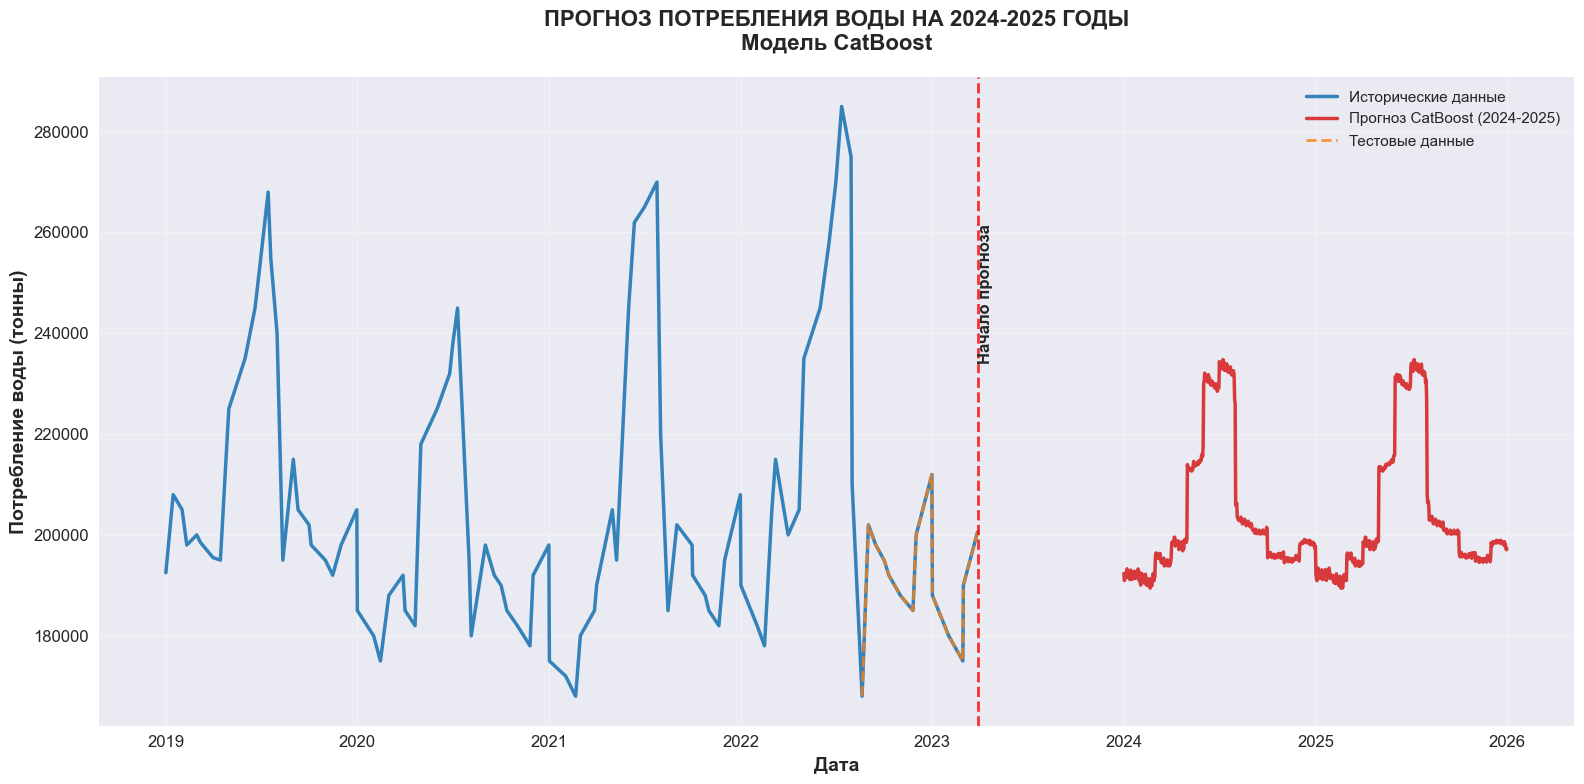

2. Создание графика остатков...


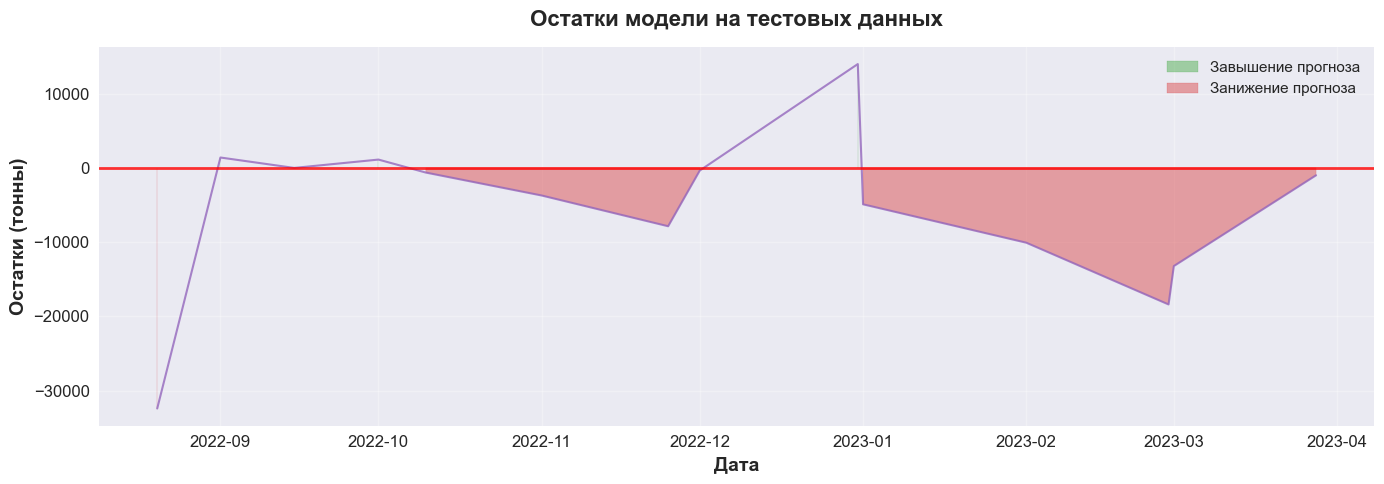

3. Создание графика сезонного анализа...


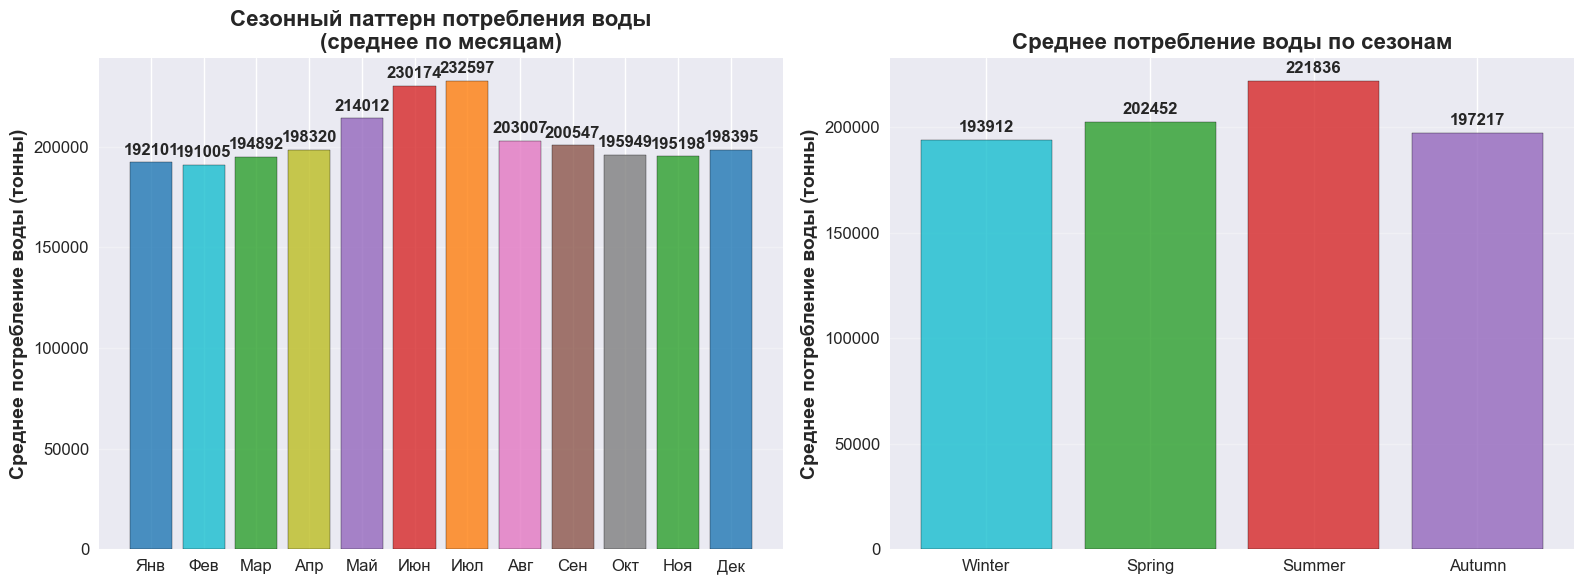

4. Создание графика месячных агрегатов...


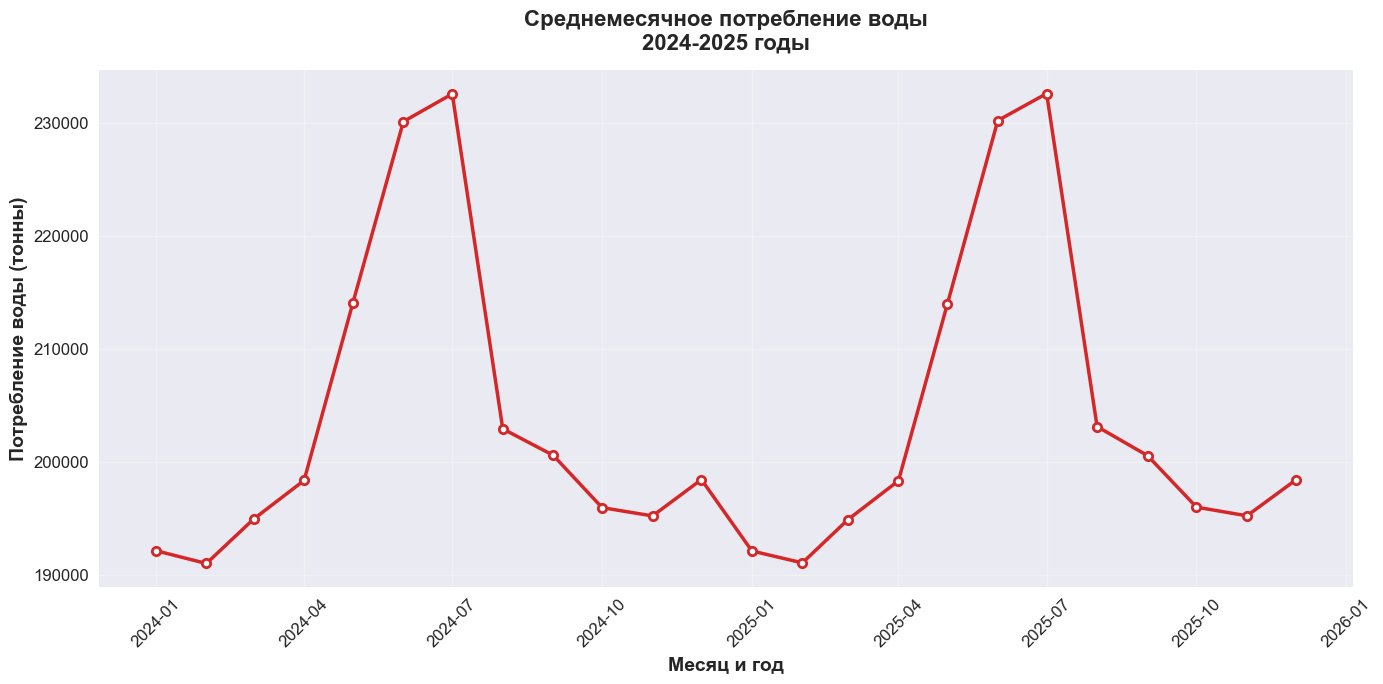

5. Создание тепловой карты...


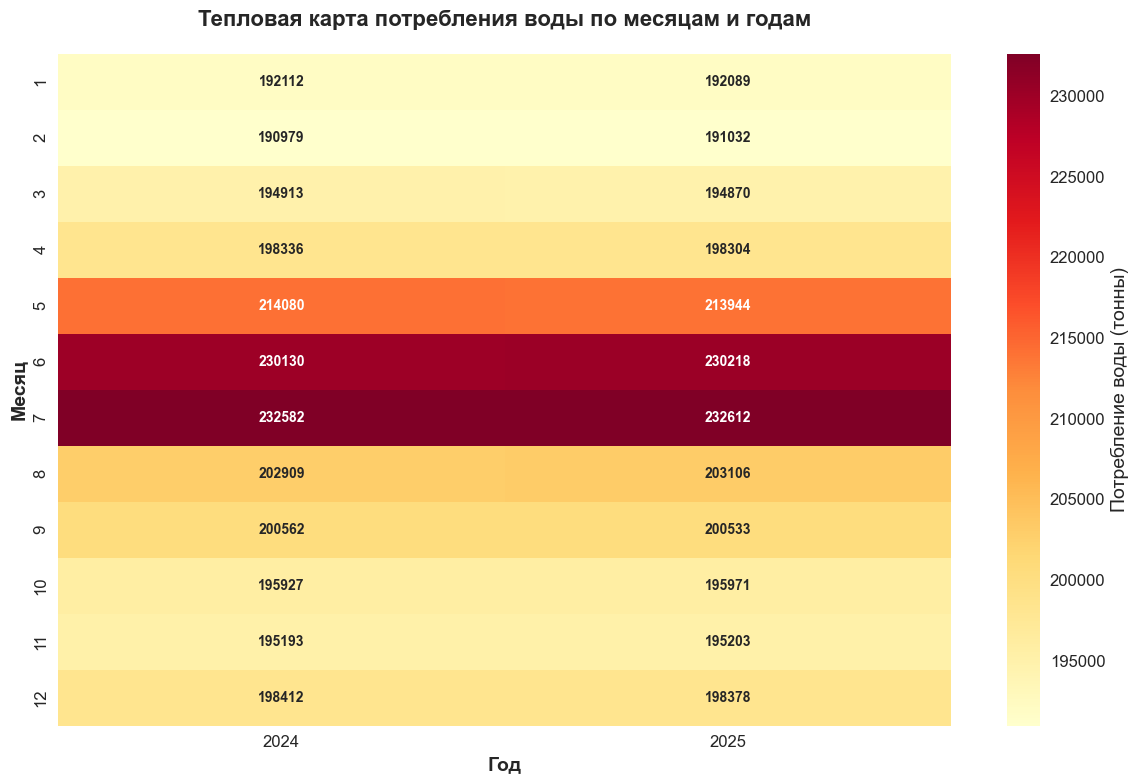

6. Создание графика важности признаков...


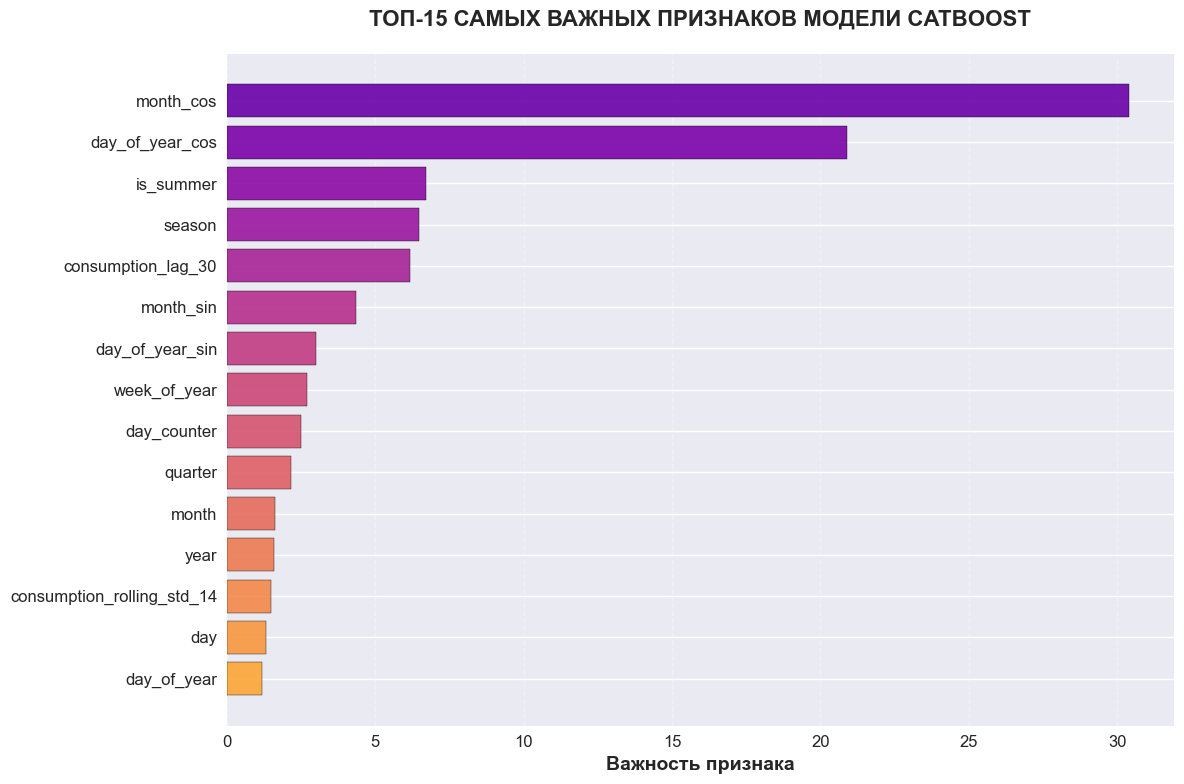

7. Создание графика анализа по сезонам и кварталам...


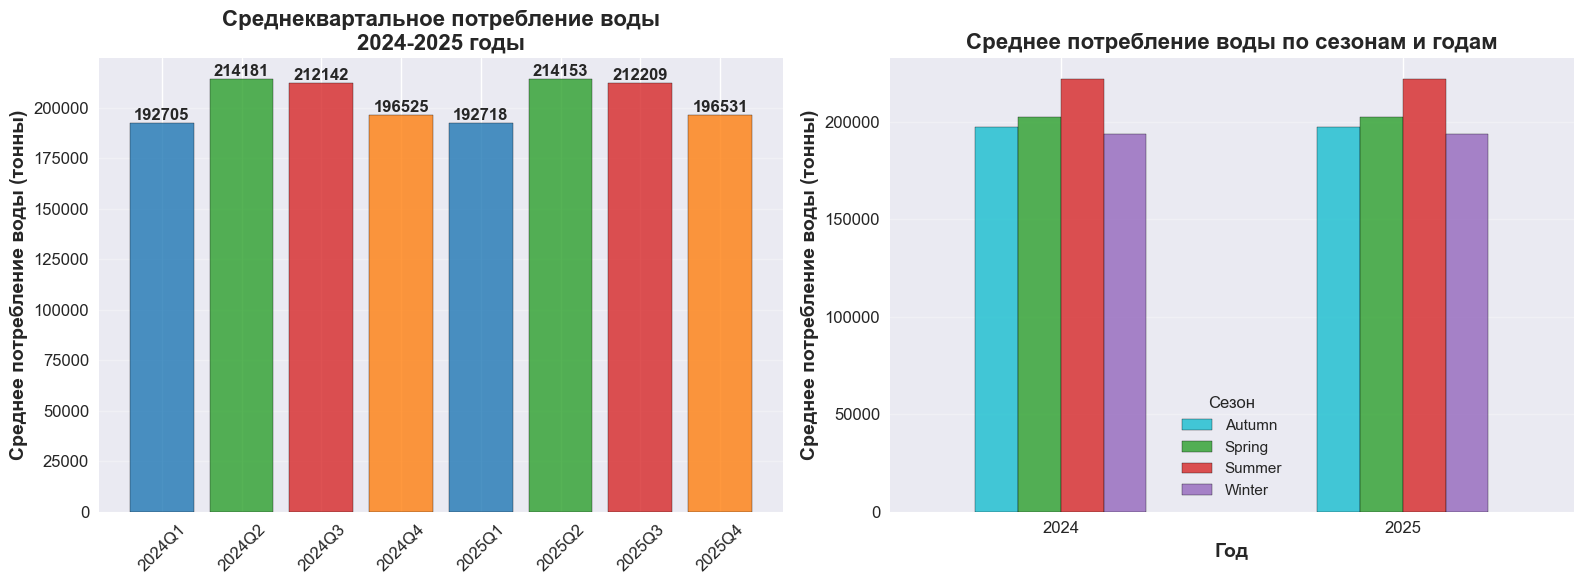

8. Создание графика сравнения по годам...


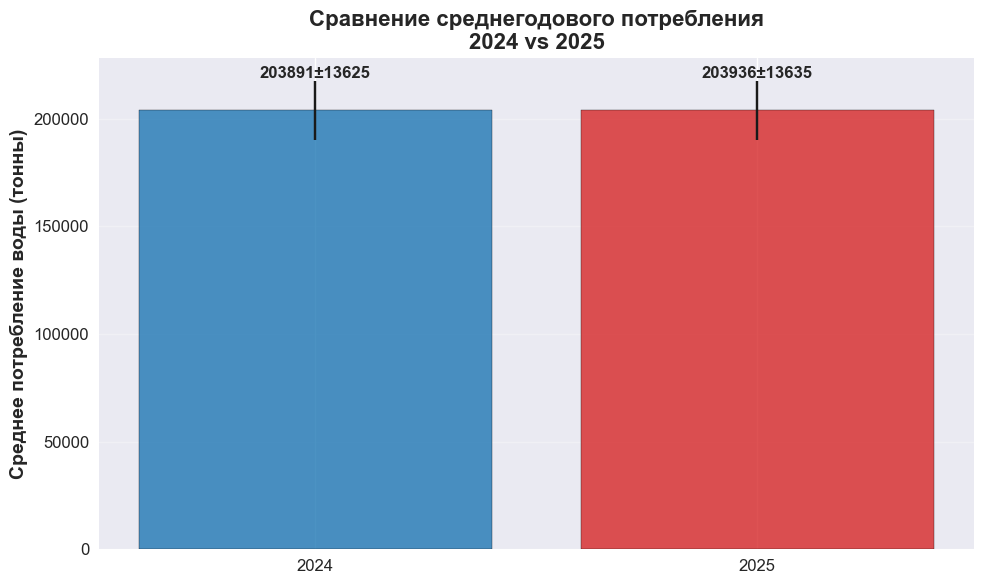


📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ ПРОГНОЗА CATBOOST

Статистика прогнозов по годам:
           mean       std       min        max     median
year                                                     
2024  203890.79  13624.74  189440.1  234789.17  198425.71
2025  203936.19  13634.66  189440.1  234789.17  198455.82

Статистика прогнозов по сезонам:
                  mean       std        min        max
season_name                                           
Autumn       197217.32   2386.15  194469.89  201499.68
Spring       202452.44   8420.86  193763.12  217551.89
Summer       221836.33  13560.46  201659.02  234789.17
Winter       193911.89   3335.05  189440.10  199094.53

Статистика прогнозов по месяцам:
            mean      std        min        max
month                                          
1      192100.89   670.26  190921.34  193423.90
2      191005.39   762.16  189440.10  192364.20
3      194891.94   795.67  193763.12  196422.06
4      198320.08   681.88  196853.13  199561.92
5      

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Улучшенные настройки стиля для лучшей читаемости
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ЯРКИЕ И КОНТРАСТНЫЕ ЦВЕТА КАК В SARIMA И ARIMA
COLORS = {
    'historical': '#1f77b4',      # Насыщенный синий
    'forecast': '#d62728',        # Яркий красный
    'test': '#ff7f0e',           # Оранжевый
    'confidence': '#ff9896',      # Светло-красный
    'accent1': '#2ca02c',         # Зеленый
    'accent2': '#9467bd',         # Фиолетовый
    'accent3': '#8c564b',         # Коричневый
    'accent4': '#e377c2',         # Розовый
    'accent5': '#7f7f7f',         # Серый
    'accent6': '#bcbd22',         # Желто-зеленый
    'accent7': '#17becf',         # Голубой
}

# Улучшенные настройки шрифтов
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18
})

# Загрузка данных
print("Загрузка данных...")
data = pd.read_csv('Water_Consumption_city_N.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date').reset_index(drop=True)

# Проверяем доступные колонки в данных
print("Доступные колонки в данных:", data.columns.tolist())

# Сохраняем оригинальные данные для визуализации
original_data = data[['date', 'water_consumption_tonnes']].copy()

# СОЗДАНИЕ ПРИЗНАКОВ ДЛЯ ВРЕМЕННЫХ РЯДОВ
print("Создание признаков...")

# Базовые временные признаки
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['quarter'] = data['date'].dt.quarter
data['day_of_year'] = data['date'].dt.dayofyear
data['week_of_year'] = data['date'].dt.isocalendar().week
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Сезонные признаки
data['season'] = data['month'] % 12 // 3 + 1
data['is_summer'] = ((data['month'] >= 6) & (data['month'] <= 8)).astype(int)
data['is_winter'] = ((data['month'] <= 2) | (data['month'] == 12)).astype(int)

# Лаговые признаки
for window in [7, 14, 30]:
    data[f'consumption_lag_{window}'] = data['water_consumption_tonnes'].shift(window)
    data[f'consumption_rolling_mean_{window}'] = data['water_consumption_tonnes'].shift(1).rolling(window).mean()
    data[f'consumption_rolling_std_{window}'] = data['water_consumption_tonnes'].shift(1).rolling(window).std()

# Трендовые признаки
data['day_counter'] = range(len(data))
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

# Удаляем строки с NaN
data = data.dropna()

# Определяем финальный набор признаков для модели
feature_columns = [
    'year', 'month', 'day', 'day_of_week', 'quarter', 'day_of_year', 
    'week_of_year', 'is_weekend', 'season', 'is_summer', 'is_winter',
    'day_counter', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos'
]

for window in [7, 14, 30]:
    feature_columns.extend([
        f'consumption_lag_{window}',
        f'consumption_rolling_mean_{window}',
        f'consumption_rolling_std_{window}'
    ])

categorical_features = ['month', 'day_of_week', 'quarter', 'season', 'is_weekend', 'is_summer', 'is_winter']

# Разделение на обучающую и тестовую выборки
print("Разделение данных...")
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index].copy()
test_data = data.iloc[split_index:].copy()

X_train = train_data[feature_columns]
y_train = train_data['water_consumption_tonnes']
X_test = test_data[feature_columns]
y_test = test_data['water_consumption_tonnes']

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Обучение модели CatBoost
print("Обучение модели CatBoost...")
model = CatBoostRegressor(
    cat_features=categorical_features,
    random_seed=42,
    depth=8,
    learning_rate=0.05,
    iterations=1000,
    early_stopping_rounds=50,
    verbose=100,
    loss_function='RMSE'
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

# Оценка модели
print("\nОценка модели на тестовых данных...")
test_predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100

print(f"MAE на тестовых данных: {mae:.2f}")
print(f"RMSE на тестовых данных: {rmse:.2f}")
print(f"MAPE на тестовых данных: {mape:.2f}%")

# СОЗДАНИЕ ДАННЫХ ДЛЯ ПРОГНОЗА НА 2024-2025
print("\nСоздание датасета для прогноза 2024-2025...")
future_dates = pd.date_range(start='2024-01-01', end='2025-12-31', freq='D')
future_data = pd.DataFrame({'date': future_dates})

# Создаем те же признаки для будущих данных
future_data['year'] = future_data['date'].dt.year
future_data['month'] = future_data['date'].dt.month
future_data['day'] = future_data['date'].dt.day
future_data['day_of_week'] = future_data['date'].dt.dayofweek
future_data['quarter'] = future_data['date'].dt.quarter
future_data['day_of_year'] = future_data['date'].dt.dayofyear
future_data['week_of_year'] = future_data['date'].dt.isocalendar().week
future_data['is_weekend'] = (future_data['day_of_week'] >= 5).astype(int)
future_data['season'] = future_data['month'] % 12 // 3 + 1
future_data['is_summer'] = ((future_data['month'] >= 6) & (future_data['month'] <= 8)).astype(int)
future_data['is_winter'] = ((future_data['month'] <= 2) | (future_data['month'] == 12)).astype(int)

# Трендовые признаки для будущего
last_day_counter = data['day_counter'].iloc[-1]
future_data['day_counter'] = range(last_day_counter + 1, last_day_counter + len(future_data) + 1)
future_data['month_sin'] = np.sin(2 * np.pi * future_data['month'] / 12)
future_data['month_cos'] = np.cos(2 * np.pi * future_data['month'] / 12)
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year'] / 365)
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year'] / 365)

# Для лаговых признаков используем последние известные значения
last_consumption = data['water_consumption_tonnes'].iloc[-1]
last_rolling_mean_7 = data['consumption_rolling_mean_7'].iloc[-1]
last_rolling_std_7 = data['consumption_rolling_std_7'].iloc[-1]

for window in [7, 14, 30]:
    future_data[f'consumption_lag_{window}'] = last_consumption
    future_data[f'consumption_rolling_mean_{window}'] = last_rolling_mean_7
    future_data[f'consumption_rolling_std_{window}'] = last_rolling_std_7

future_features = future_data[feature_columns]

# Прогнозирование
print("Прогнозирование потребления воды на 2024-2025...")
future_predictions = model.predict(future_features)

# СОЗДАНИЕ ФИНАЛЬНОГО ДАТАФРЕЙМА С РЕЗУЛЬТАТАМИ (ДОБАВЛЯЕМ SEASON)
print("Создание финального датафрейма с результатами...")
results = pd.DataFrame({
    'date': future_dates,
    'predicted_water_consumption_tonnes': future_predictions,
    'season': future_data['season']  # Добавляем столбец season
})

# Добавление дополнительных колонок для агрегации
results['year'] = results['date'].dt.year
results['month'] = results['date'].dt.month
results['quarter'] = results['date'].dt.quarter

# Добавляем названия сезонов для лучшей читаемости
season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
results['season_name'] = results['season'].map(season_mapping)

print("Первые 5 строк финального датафрейма:")
print(results.head())

# УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ С ЯРКИМИ ЦВЕТАМИ
print("\nСоздание улучшенных графиков с яркими цветами...")

# 1. ОСНОВНОЙ ГРАФИК: исторические данные + прогноз
print("1. Создание основного графика...")
fig, ax = plt.subplots(figsize=(16, 8))

# Используем яркие контрастные цвета
ax.plot(original_data['date'], original_data['water_consumption_tonnes'], 
        label='Исторические данные', color=COLORS['historical'], linewidth=2.5, alpha=0.9)
ax.plot(results['date'], results['predicted_water_consumption_tonnes'], 
        label='Прогноз CatBoost (2024-2025)', color=COLORS['forecast'], linewidth=2.5, alpha=0.9)

# Добавляем тестовые данные если они есть
if len(test_data) > 0:
    test_dates = test_data['date']
    ax.plot(test_dates, test_data['water_consumption_tonnes'], 
            label='Тестовые данные', color=COLORS['test'], linewidth=2, alpha=0.8, linestyle='--')

# Вертикальная линия разделения
last_historical_date = original_data['date'].iloc[-1]
ax.axvline(x=last_historical_date, color='red', linestyle='--', alpha=0.8, linewidth=2)
ax.text(last_historical_date, ax.get_ylim()[1]*0.9, 'Начало прогноза', 
        rotation=90, verticalalignment='top', fontweight='bold')

ax.set_title('ПРОГНОЗ ПОТРЕБЛЕНИЯ ВОДЫ НА 2024-2025 ГОДЫ\nМодель CatBoost', 
             fontweight='bold', pad=20)
ax.set_ylabel('Потребление воды (тонны)', fontweight='bold')
ax.set_xlabel('Дата', fontweight='bold')
ax.legend(framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. ГРАФИК ОСТАТКОВ
print("2. Создание графика остатков...")
if len(test_data) > 0:
    fig, ax = plt.subplots(figsize=(14, 5))
    
    test_residuals = test_data['water_consumption_tonnes'] - test_predictions
    dates = test_data['date']
    
    # Яркие цвета для остатков
    ax.plot(dates, test_residuals, color=COLORS['accent2'], linewidth=1.5, alpha=0.8)
    ax.axhline(y=0, color='red', linestyle='-', alpha=0.8, linewidth=2)
    ax.fill_between(dates, test_residuals, 0, 
                   where=(test_residuals >= 0), color=COLORS['accent1'], alpha=0.4, label='Завышение прогноза')
    ax.fill_between(dates, test_residuals, 0, 
                   where=(test_residuals < 0), color=COLORS['forecast'], alpha=0.4, label='Занижение прогноза')
    
    ax.set_title('Остатки модели на тестовых данных', fontweight='bold', pad=15)
    ax.set_ylabel('Остатки (тонны)', fontweight='bold')
    ax.set_xlabel('Дата', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3. СЕЗОННЫЙ АНАЛИЗ С УЧЕТОМ SEASON
print("3. Создание графика сезонного анализа...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Сезонный паттерн по месяцам
seasonal_pattern = results.groupby('month')['predicted_water_consumption_tonnes'].mean()
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

# Яркие цвета для месяцев
month_colors = [COLORS['historical'], COLORS['accent7'], COLORS['accent1'], 
                COLORS['accent6'], COLORS['accent2'], COLORS['forecast'],
                COLORS['test'], COLORS['accent4'], COLORS['accent3'],
                COLORS['accent5'], COLORS['accent1'], COLORS['historical']]

bars = ax1.bar(months, seasonal_pattern.values, alpha=0.8, edgecolor='black', color=month_colors)
ax1.set_title('Сезонный паттерн потребления воды\n(среднее по месяцам)', fontweight='bold')
ax1.set_ylabel('Среднее потребление воды (тонны)', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, v in enumerate(seasonal_pattern.values):
    ax1.text(i, v + seasonal_pattern.values.max() * 0.01, f'{v:.0f}', 
            ha='center', va='bottom', fontweight='bold')

# Анализ по сезонам
seasonal_agg = results.groupby('season_name')['predicted_water_consumption_tonnes'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

# Цвета для сезонов
season_colors = [COLORS['accent7'], COLORS['accent1'], COLORS['forecast'], COLORS['accent2']]

bars_season = ax2.bar(seasonal_agg.index, seasonal_agg.values, alpha=0.8, 
                     edgecolor='black', color=season_colors)
ax2.set_title('Среднее потребление воды по сезонам', fontweight='bold')
ax2.set_ylabel('Среднее потребление воды (тонны)', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, v in enumerate(seasonal_agg.values):
    ax2.text(i, v + seasonal_agg.values.max() * 0.01, f'{v:.0f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. МЕСЯЧНЫЕ АГРЕГАТЫ
print("4. Создание графика месячных агрегатов...")
fig, ax = plt.subplots(figsize=(14, 7))

monthly_agg = results.groupby(['year', 'month'])['predicted_water_consumption_tonnes'].mean().reset_index()
monthly_agg['date'] = pd.to_datetime(monthly_agg['year'].astype(str) + '-' + monthly_agg['month'].astype(str) + '-01')

ax.plot(monthly_agg['date'], monthly_agg['predicted_water_consumption_tonnes'], 
        marker='o', linewidth=2.5, markersize=6, color=COLORS['forecast'],
        markerfacecolor='white', markeredgewidth=2, markeredgecolor=COLORS['forecast'])
ax.set_title('Среднемесячное потребление воды\n2024-2025 годы', fontweight='bold', pad=15)
ax.set_ylabel('Потребление воды (тонны)', fontweight='bold')
ax.set_xlabel('Месяц и год', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 5. ТЕПЛОВАЯ КАРТА ПОТРЕБЛЕНИЯ
print("5. Создание тепловой карты...")
fig, ax = plt.subplots(figsize=(12, 8))

heatmap_data = results.pivot_table(values='predicted_water_consumption_tonnes', 
                                 index='month', columns='year', aggfunc='mean')

# Яркая тепловая карта
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
           cbar_kws={'label': 'Потребление воды (тонны)'},
           annot_kws={'size': 10, 'weight': 'bold'}, ax=ax)

ax.set_title('Тепловая карта потребления воды по месяцам и годам', 
             fontweight='bold', pad=20)
ax.set_xlabel('Год', fontweight='bold')
ax.set_ylabel('Месяц', fontweight='bold')

plt.tight_layout()
plt.show()

# 6. ВАЖНОСТЬ ПРИЗНАКОВ
print("6. Создание графика важности признаков...")
fig, ax = plt.subplots(figsize=(12, 8))

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(15)

# Яркая цветовая схема для важности признаков
colors_importance = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_features)))
ax.barh(top_features['feature'], top_features['importance'], 
        color=colors_importance, edgecolor='black', alpha=0.9)
ax.set_xlabel('Важность признака', fontweight='bold')
ax.set_title('ТОП-15 САМЫХ ВАЖНЫХ ПРИЗНАКОВ МОДЕЛИ CATBOOST', 
             fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, linestyle='--', axis='x')

plt.tight_layout()
plt.show()

# 7. АНАЛИЗ ПО СЕЗОНАМ И КВАРТАЛАМ
print("7. Создание графика анализа по сезонам и кварталам...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Квартальные агрегаты
quarterly_agg = results.groupby(['year', 'quarter'])['predicted_water_consumption_tonnes'].mean().reset_index()
quarterly_agg['period'] = quarterly_agg['year'].astype(str) + 'Q' + quarterly_agg['quarter'].astype(str)

# Яркие цвета для кварталов
quarter_colors = [COLORS['historical'], COLORS['accent1'], COLORS['forecast'], COLORS['test']]

bars_quarter = ax1.bar(quarterly_agg['period'], quarterly_agg['predicted_water_consumption_tonnes'], 
                      alpha=0.8, edgecolor='black', color=quarter_colors * 2)
ax1.set_title('Среднеквартальное потребление воды\n2024-2025 годы', fontweight='bold')
ax1.set_ylabel('Среднее потребление воды (тонны)', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars_quarter:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5, f'{height:.0f}', 
            ha='center', va='bottom', fontweight='bold')

# Годовые агрегаты с разбивкой по сезонам
season_year_agg = results.groupby(['year', 'season_name'])['predicted_water_consumption_tonnes'].mean().unstack()

# Яркие цвета для сезонов
season_plot_colors = [COLORS['accent7'], COLORS['accent1'], COLORS['forecast'], COLORS['accent2']]
season_year_agg.plot(kind='bar', ax=ax2, alpha=0.8, edgecolor='black', color=season_plot_colors)
ax2.set_title('Среднее потребление воды по сезонам и годам', fontweight='bold')
ax2.set_ylabel('Среднее потребление воды (тонны)', fontweight='bold')
ax2.set_xlabel('Год', fontweight='bold')
ax2.legend(title='Сезон')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# 8. СРАВНЕНИЕ ПО ГОДАМ
print("8. Создание графика сравнения по годам...")
fig, ax = plt.subplots(figsize=(10, 6))

yearly_comparison = results.groupby('year')['predicted_water_consumption_tonnes'].agg(['mean', 'std'])

years = yearly_comparison.index.astype(str)
x_pos = np.arange(len(years))

# Контрастные цвета для годов
year_colors = [COLORS['historical'], COLORS['forecast']]

bars = ax.bar(x_pos, yearly_comparison['mean'], yerr=yearly_comparison['std'], 
             capsize=5, color=year_colors, alpha=0.8, edgecolor='black')
ax.set_title('Сравнение среднегодового потребления\n2024 vs 2025', fontweight='bold')
ax.set_ylabel('Среднее потребление воды (тонны)', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(years)
ax.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(yearly_comparison['mean']):
    ax.text(i, v + yearly_comparison['std'].iloc[i] + 10, 
           f'{v:.0f}±{yearly_comparison["std"].iloc[i]:.0f}', 
           ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# СТАТИСТИЧЕСКИЙ АНАЛИЗ И ВЫВОДЫ
print("\n" + "="*80)
print("📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ ПРОГНОЗА CATBOOST")
print("="*80)

# Статистика по годам
print("\nСтатистика прогнозов по годам:")
yearly_stats = results.groupby('year')['predicted_water_consumption_tonnes'].agg([
    'mean', 'std', 'min', 'max', 'median'
]).round(2)
print(yearly_stats)

# Статистика по сезонам
print("\nСтатистика прогнозов по сезонам:")
seasonal_stats = results.groupby('season_name')['predicted_water_consumption_tonnes'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)
print(seasonal_stats)

# Статистика по месяцам
print("\nСтатистика прогнозов по месяцам:")
monthly_stats = results.groupby('month')['predicted_water_consumption_tonnes'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)
print(monthly_stats)

# Основные выводы
print("\n📋 ОСНОВНЫЕ ВЫВОДЫ:")
print(f"• Среднее дневное потребление в 2024: {yearly_stats.loc[2024, 'mean']:,.0f} т")
print(f"• Среднее дневное потребление в 2025: {yearly_stats.loc[2025, 'mean']:,.0f} т")
print(f"• Максимальное потребление в прогнозе: {results['predicted_water_consumption_tonnes'].max():,.0f} т")
print(f"• Минимальное потребление в прогнозе: {results['predicted_water_consumption_tonnes'].min():,.0f} т")
print(f"• Амплитуда колебаний: {results['predicted_water_consumption_tonnes'].max() - results['predicted_water_consumption_tonnes'].min():,.0f} т")

# Анализ сезонности
max_season = seasonal_stats['mean'].idxmax()
min_season = seasonal_stats['mean'].idxmin()
max_month = monthly_stats['mean'].idxmax()
min_month = monthly_stats['mean'].idxmin()
month_names = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 
               'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

print(f"\n🌡️  СЕЗОННЫЙ АНАЛИЗ:")
print(f"• Самый высокий сезон: {max_season} ({seasonal_stats.loc[max_season, 'mean']:,.0f} т)")
print(f"• Самый низкий сезон: {min_season} ({seasonal_stats.loc[min_season, 'mean']:,.0f} т)")
print(f"• Пик потребления: {month_names[max_month-1]} ({monthly_stats.loc[max_month, 'mean']:,.0f} т)")
print(f"• Минимум потребления: {month_names[min_month-1]} ({monthly_stats.loc[min_month, 'mean']:,.0f} т)")

# Рекомендации
print(f"\n💎 РЕКОМЕНДАЦИИ НА ОСНОВЕ CATBOOST:")
trend_change = ((yearly_stats.loc[2025, 'mean'] - yearly_stats.loc[2024, 'mean']) / yearly_stats.loc[2024, 'mean']) * 100
if trend_change > 0:
    print(f"• Ожидается рост потребления на {trend_change:+.1f}% в 2025 году")
else:
    print(f"• Ожидается снижение потребления на {abs(trend_change):.1f}% в 2025 году")

print(f"• Подготовиться к сезонным пикам в {max_season}")
print(f"• Оптимизировать инфраструктуру для диапазона {results['predicted_water_consumption_tonnes'].min():,.0f} - {results['predicted_water_consumption_tonnes'].max():,.0f} т/день")

# Топ важных признаков
print(f"\n🔍 ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.3f}")

# Сохранение результатов С ДОБАВЛЕННЫМ SEASON
output_filename = 'water_consumption_forecast_CatBoost_2024_2025.csv'
results.to_csv(output_filename, index=False)
print(f"\n💾 Прогноз CatBoost сохранен в файл: {output_filename}")
print(f"   Файл содержит столбцы: {', '.join(results.columns.tolist())}")

print("\n✅ ПРОГНОЗИРОВАНИЕ CATBOOST УСПЕШНО ЗАВЕРШЕНО!")